---
# <h1 style="color:olive;"><b>1 - Library</b></h1>

In [1]:
#!pip install opencv-python numpy face_recognition face_recognition_models scikit-image deepface mediapipe

In [2]:
#!pip install matplotlib diffusers transformers accelerate safetensors torch pillow datasets

In [3]:
#!pip install facenet-pytorch retina-face dlib

In [4]:
'''!pip uninstall diffusers torch torchvision torchaudio -y
!pip cache purge
!pip install torch torchvision torchaudio
!pip install diffusers==0.35.2'''

'!pip uninstall diffusers torch torchvision torchaudio -y\n!pip cache purge\n!pip install torch torchvision torchaudio\n!pip install diffusers==0.35.2'

In [5]:
!python --version

Python 3.10.1


In [6]:
import argparse
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import face_recognition
import torch
import pandas as pd
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

from GetFaceFunc import (get_subset_from_zip, abv_avg_quality_randomizer)
from FaceColorFunc import (get_face_mask, shift_skin_color, change_face_color)
from EvalFace import FaceDetected, close_face_detectors
from Analysis import(SingleColComparison, DfComparison, colorShadeComparison, DfColorShade, colorShadeColumn)

c:\Users\Daniela\Desktop\Fac\M.IA\ano_1\semestre_1\IAS\Projeto_Individual\.venvIAS\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

---

# <h1 style="color:olive;"><b>2 - Dataset Selection and Preparation</b></h1>

## <h2 style="color:olive;"><b>2.1 - Chose Dataset </b></h2>

When working with computer vision models that process human faces, it is essential to acknowledge the ethical considerations of using people’s images. Facial data is inherently personal and sensitive, and misuse can affect individual privacy and social fairness. Research and applications should respect consent, avoid reinforcement of harmful stereotypes, and be transparent about how data is sourced and used. In the context of algorithmic bias research, these concerns are especially critical; models that perform differently across demographic groups can inadvertently perpetuate inequity if deployed without careful evaluation and mitigation.

Several publicly available face datasets have been created to support research in recognition, alignment, and attribute analysis. Examples include **UTKFace**, which contains a wide range of ages with rough annotations for age, gender, and race; **VGGFace2**, a large collection of identities used for training high-capacity recognition models; and **DiF** (Diversity in Faces), which focuses on granular facial characteristics. Each of these datasets has strengths and limitations: some are extensive but imbalanced across demographic groups, others provide rich annotations but lack uniform preprocessing. For a research project comparing model behavior across pigmentation and detection performance, it is important to balance dataset quality, demographic representation, and practical considerations such as storage and annotation consistency.

During dataset selection, **UTKFace** was considered due to its broad age and race labels. However, UTKFace proved challenging in practice: many images contained misclassified attributes or poor quality labels, and the size of the full dataset made it cumbersome for prototyping and reproducible experimentation. After evaluating multiple alternatives, the **FairFace** dataset was chosen as the primary source for experimental images. *FairFace* was introduced in the work [FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age (Kärkkäinen and Joo, WACV 2021)](https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf), and was explicitly designed to provide a balanced representation across race, gender, and age subgroups. By mitigating skew in demographic distribution, FairFace supports more equitable evaluation of model performance and reduces confounds related to dataset bias. Its curated and aligned images make it suitable for controlled experiments in facial analysis and bias measurement.

## <h2 style="color:olive;"><b>2.2 - Import Dataset </b></h2>

The FairFace dataset is distributed through the HuggingFace `datasets` library and is organized as a `DatasetDict` with predefined training and validation splits. Each split contains face images alongside demographic annotations that are relevant for fairness-oriented analysis. In this project, the dataset structure enables systematic comparison of facial recognition behavior across demographic groups while maintaining a clear separation between training and evaluation data.

The dataset is structured as follows:

```text
DatasetDict({
    train: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 86744
    })
    validation: Dataset({
        features: ['image', 'age', 'gender', 'race', 'service_test'],
        num_rows: 10954
    })
})


Each row contains an aligned facial image and a set of categorical attributes:

- *image*: RGB face image (PIL format, size 224×224)

- *age*: age group label:
    - **0**: 0–2

    - **1**: 3–9

    - **2**: 10–19

    - **3**: 20–29

    - **4**: 30–39

    - **5**: 40–49

    - **6**: 50–59

    - **7**: 60–69

- *gender*: binary label:
    - **0**: Male

    - **1**: Female

- *race*: categorical race label:

    - **0**: East Asian

    - **1**: Indian

    - **2**: Black

    - **3**: White

    - **4**: Middle Eastern

    - **5**: Latino / Hispanic

    - **6**: Southeast Asian

- *service_test*: boolean flag indicating images reserved for service-level evaluation

The dataset is loaded using the HuggingFace identifier [HuggingFaceM4/FairFace](https://huggingface.co/datasets/HuggingFaceM4/FairFace), which provides multiple resolution variants. Two commonly used variants are:

| Variant  | Meaning                                     | Typical use                                     |
| -------- | ------------------------------------------- | ----------------------------------------------- |
| *"1.25"* | **Higher-resolution images** (larger scale) | Better visual detail, higher accuracy potential |
| *"0.25"* | **Lower-resolution images** (downscaled)    | Faster training, lower memory usage             |


For this project, the "0.25" variant was selected to reduce computational overhead and storage requirements while preserving sufficient facial detail for detection-based experiments.

In [3]:
from datasets import load_dataset

dataset = load_dataset("HuggingFaceM4/FairFace", "0.25")

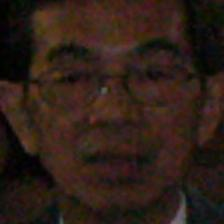

In [4]:
#Test 
face_foto = dataset['train'][0]['image']
face_foto

In [5]:
def pil_to_rgb_np(img_pil, style = "RGB"):
    """
    Converts PIL Image to NumPy uint8 array in the requested color style
    (e.g., 'RGB', 'L', 'RGBA').
    """
    return np.array(img_pil.convert(style))

face_foto_rgb = pil_to_rgb_np(face_foto)
face_foto_bgr = cv2.cvtColor(face_foto_rgb, cv2.COLOR_RGB2BGR)

---

# <h1 style="color:olive;"><b>3 - Skin Pigmentation Manipulation Pipeline</b></h1>

This section describes the methodology used to artificially alter facial skin pigmentation in a controlled and reproducible manner.


## <h2 style="color:olive;"><b>3.1 - Pigmentation Manipulation Strategies </b></h2>

Before implementing the final pipeline, several approaches for generating artificially recolored facial images were considered. These approaches differ in complexity, realism, and suitability for controlled bias analysis. The main objective was to modify skin pigmentation while preserving facial structure, expression, and contextual information as much as possible.

The following options were evaluated:

| Option | Description | Pros | Cons |
|------:|-------------|------|------|
| **1** | Apply a global color filter over the entire image | Very simple to implement; fast | Alters background and clothing; unrealistic; confounds face vs background effects |
| **2** | Detect face bounding box and recolor the rectangular region | Localized to face area; relatively simple | Poor alignment with facial contours; includes hair and background; visible artifacts |
| **3** | Detect facial landmarks, isolate skin region, recolor skin, and blend borders | High realism; preserves facial structure; controlled pigmentation change | More complex implementation; requires reliable face detection |

An additional alternative was briefly considered: using a neural network to directly repaint faces with different skin tones (e.g., image-to-image translation or style transfer). While potentially capable of producing highly realistic results, this approach was deemed unsuitable for the scope of this project due to high computational cost, increased methodological opacity, and difficulty in isolating pigmentation as the only changing variable.

Based on these considerations, **Option 3** was selected as the final approach. This method provides a balance between realism and control, allowing pigmentation to be altered while preserving facial geometry and minimizing unintended changes to non-skin regions.

To implement this strategy, **MediaPipe Face Mesh** was used for landmark-based face detection. This approach offers:
- Accurate facial contours and key landmarks (eyes, lips, face outline)
- High computational efficiency suitable for large-scale processing
- Robust performance on cropped and aligned face images  

Although Face Mesh does not explicitly label skin versus hair, its dense landmark representation enables effective approximation of skin regions for the purposes of this experiment.


## <h2 style="color:olive;"><b>3.2 - Facial Region Detection </b></h2>


The first step in the pigmentation pipeline is the extraction of the facial region using the ``get_face_mask`` function. Given an input image, this function produces a masked version in which the detected facial silhouette is preserved, while all remaining pixels are replaced by a uniform gray background.

Face localization is performed using **MediaPipe Face Mesh**, relying exclusively on the outer face contour landmarks to approximate the facial silhouette. This polygon-based representation yields a tighter and more anatomically consistent region than rectangular bounding boxes, without depending on fine-grained semantic segmentation of facial components such as eyes or lips. A slight mask smoothing is applied to reduce hard boundary artifacts. If no face is detected, the function explicitly signals failure, allowing the image to be skipped in later processing stages.


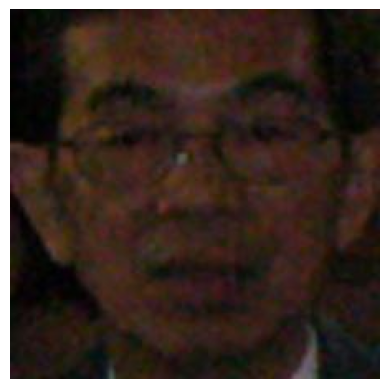

In [6]:
plt.imshow(face_foto_rgb) #img_rgb  #padded cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.show()

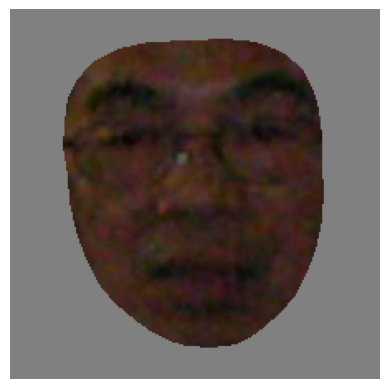

In [7]:
masked_face = get_face_mask(face_foto_rgb)
#print(masked_face)
plt.imshow(masked_face)
plt.axis("off")
plt.show()

## <h2 style="color:olive;"><b>3.3 - Skin Pigmentation Transformation </b></h2>

With the face region isolated, skin tone modification is applied using the ``shift_skin_color`` function. This function recolors the visible skin region toward a target color while preserving relative shading and illumination patterns across the face.

The transformation is performed in the **CIELAB color space**, where the average skin color of the face is first computed and then *shifted* toward the target color using a *global displacement vector* in LAB space. This vector is applied exclusively to skin pixels—identified via the gray background mask—ensuring that non-facial regions remain unaffected. Operating in LAB space helps *preserve perceptual consistency, maintaining shadows, highlights, and local contrast* while altering overall pigmentation. The recoloring step is integrated into the broader pipeline via the ``change_face_color`` function.


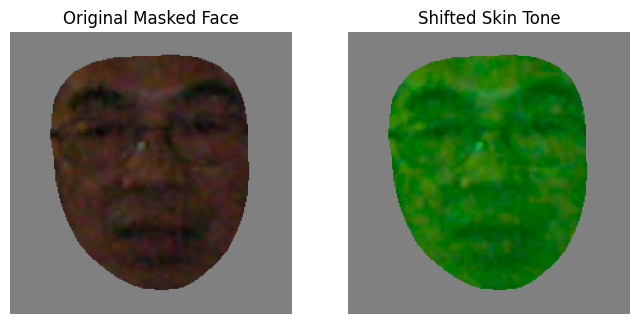

In [8]:
colored_face_mask, _ = shift_skin_color(masked_face, (0,110,0))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(masked_face); plt.title("Original Masked Face"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(colored_face_mask); plt.title("Shifted Skin Tone"); plt.axis("off")
plt.show()

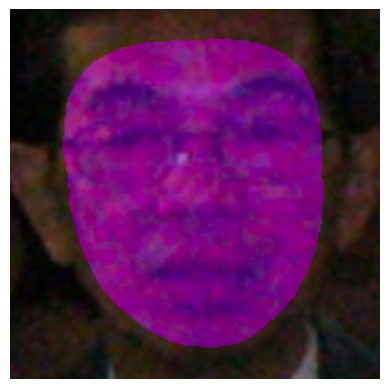

In [9]:
oainted_face = change_face_color(face_foto_bgr, (128, 0, 128)) #img_bgr
plt.imshow(oainted_face)
plt.axis("off")
plt.show()

## <h2 style="color:olive;"><b>3.4 - Boundary Blending and Smoothing </b></h2>

To prevent sharp edges or halo artifacts at the boundary between recolored skin and the surrounding background, a blending step is applied as part of the ``change_face_color`` pipeline. This step enforces a gradual visual transition between altered and unaltered regions of the image.

When enabled, the ``delta_falloff_recolor`` function propagates the LAB-space color displacement vector beyond the face silhouette, modulating its magnitude according to the pixel-wise distance from the facial boundary. The displacement is applied at full strength near the edge of the face and *smoothly attenuated with increasing distance*, eventually vanishing in the far background. This distance-based falloff preserves the original background appearance while *avoiding abrupt chromatic discontinuities*, resulting in more natural transitions and improved overall realism.

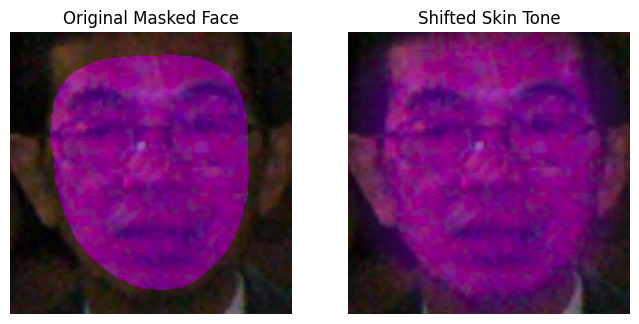

In [10]:
oainted_face = change_face_color(face_foto_bgr, (128, 0, 128))
oainted_face_blur = change_face_color(img = face_foto_bgr, color = (128, 0, 128), smooth = 15)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(oainted_face); plt.title("Original Masked Face"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(oainted_face_blur); plt.title("Shifted Skin Tone"); plt.axis("off")
plt.show()

## <h2 style="color:olive;"><b>3.5 - Color Palette Designt </b></h2>

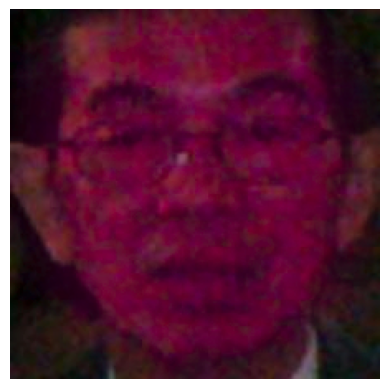

In [11]:
#Test set -> visually analyse color of choosing

oainted_face_blur = change_face_color(img = face_foto_bgr, color = (102, 0, 51), smooth = 15)
plt.imshow(oainted_face_blur)
plt.axis("off")
plt.show()

In [12]:
#(102, 51, 0), #orange
#(51, 25, 0), # orange dark

palet = [
    ("Red", (102, 0, 0), "light"), # Red
    ("Red", (51, 0, 0), "dark"), # Red, dark 
    ("yellow", (102, 102, 0), "light"), # yellow
    ("yellow", (51, 51, 0), "dark"), # yellow dark
    ("green", (0, 102, 0), "light"), # green
    ("green", (0, 51, 0), "dark"), # green dark
    ("blue", (0, 102, 102), "light"), # blue (mix)
    ("blue", (0, 51, 51), "dark"), # blue (mix) dark
    ("indigo", (0, 0, 102), "light"), # indigo
    ("indigo", (0, 0, 51), "dark"), # indigo dark
    ("roxo", (102, 0, 102), "light"), #roxo
    ("roxo", (51, 0, 51), "dark"), #roxo dark
    ]


The color palette was constructed to systematically test facial recognition robustness under controlled chromatic shifts by selecting six clearly distinct hues (*red*, *yellow*, *green*, *blue*, *indigo*, and *purple*) each represented in both **light** and **dark** variants. This pairing allows separation of hue effects from intensity effects while avoiding saturation that would obscure facial detail.

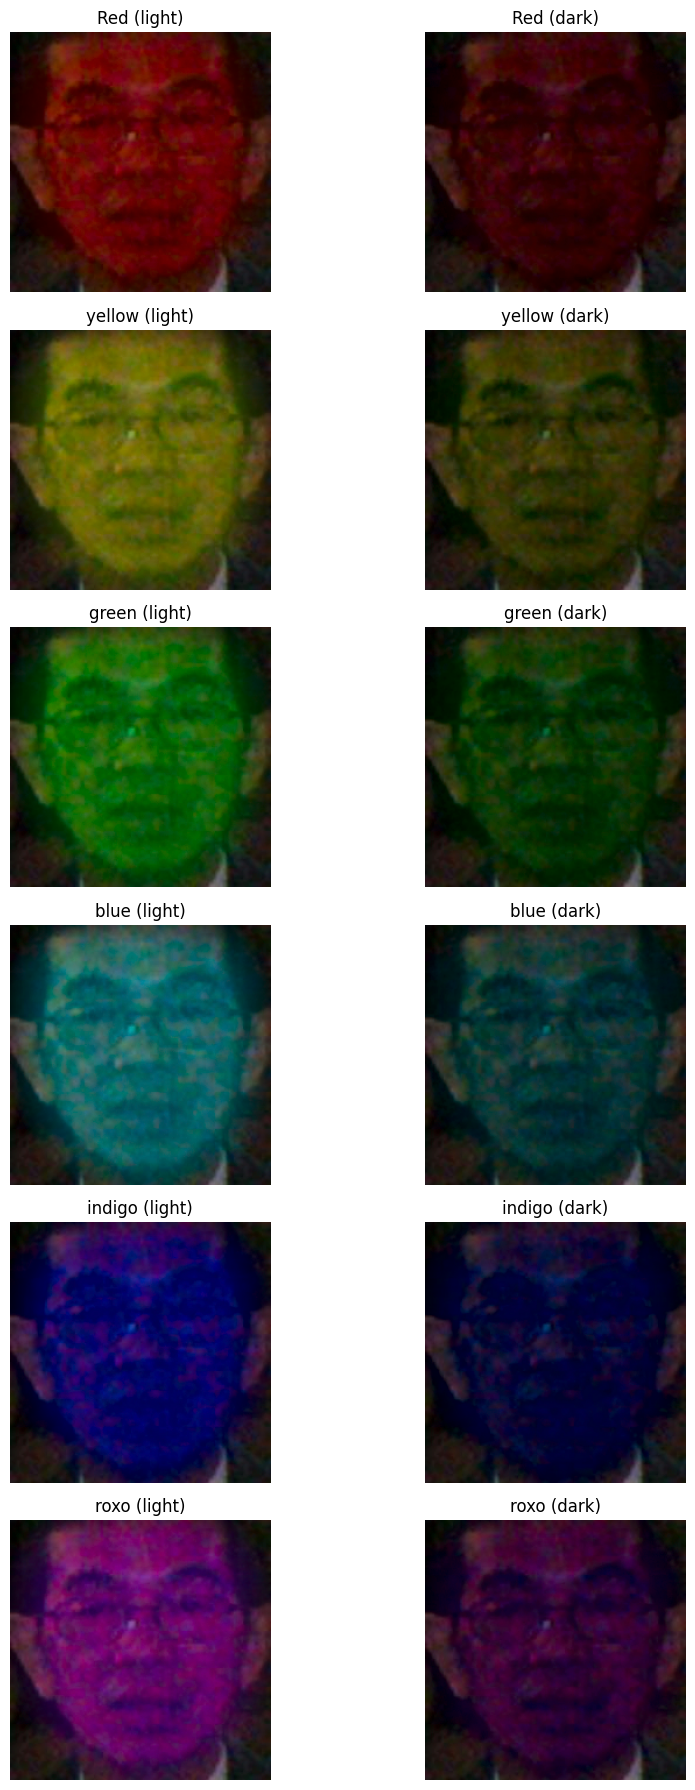

In [13]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10, 18))

rows = [0, 2, 4, 6, 8, 10]

for i, idx in enumerate(rows):
    painted_1 = change_face_color(
        img=face_foto_bgr,
        color=palet[idx][1],
        smooth=15
    )
    painted_2 = change_face_color(
        img=face_foto_bgr,
        color=palet[idx + 1][1],
        smooth=15
    )

    ax[i, 0].imshow(painted_1)
    ax[i, 0].set_title(f"{palet[idx][0]} ({palet[idx][2]})")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(painted_2)
    ax[i, 1].set_title(f"{palet[idx+1][0]} ({palet[idx+1][2]})")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()


---
# <h1 style="color:olive;"><b> 4 - Facial Recognition Evaluation</b></h1>

To evaluate how face detection models respond to unseen skin pigmentation changes, several widely used face recognition pipelines are tested. The goal is not to measure identity recognition accuracy, but rather whether a face is detected at all, allowing comparison of robustness across models trained on datasets with different demographic balances.

The selected models represent distinct training regimes and biases:

- **MediaPipe Face Detection**
Trained on a relatively balanced and diverse corpus; used here as a strong general-purpose baseline.

- **MTCNN (Mixed Training Sources)**
Commonly trained on datasets similar in distribution to UTKFace or DiF, providing a mid-range reference in terms of demographic balance.

- **Dlib HOG Face Detector**
A classical, feature-based detector used as a biased baseline, known to underperform on non-standard lighting and skin tones.

Each model outputs a binary result indicating whether a face was detected in the image.

Result Storage Format

Detection outcomes are stored in a tabular structure to facilitate later statistical analysis.

| Column       | Description                                                                        |
| ------------ | ---------------------------------------------------------------------------------- |
| `id`         | Unique identifier derived from the original image index with an added color suffix |
| `old_img_id` | Index of the original (unmodified) image                                           |
| `age`        | Age group label of the subject                                                     |
| `sex`        | Gender label (male / female)                                                       |
| `race`       | Race label as defined by the FairFace dataset                                      |
| `color`      | Applied facial color                                                               |
| `shade`      | Light or dark variant of the color                                                 |
| `y_mediapipe`   | Binary detection result of mediapipe (1 = detected, 0 = not detected)                                                        |
| `y_dlib_hog`          | Binary detection result of dlib_hog (1 = detected, 0 = not detected)                           |
| `y_mtcnn`          | Binary detection result of mtcnn (1 = detected, 0 = not detected)                           |


In [ ]:
FR_list = ["mediapipe", "dlib_hog", "mtcnn"]

rows = []

start_idx = 13336
stop_idx = 50000
subset = dataset["train"].select(range(start_idx, stop_idx))
#for idx, row in enumerate(dataset["train"][start_idx:], start=start_idx): #dataset["train"]

for idx, row in enumerate(subset, start=start_idx):
    print(f"curr id =\n ---> {idx}")

    base_id = idx
    age = row["age"]
    sex = row["gender"]     
    race = row["race"]

    face_foto_rgb = pil_to_rgb_np(row["image"])
    face_foto_bgr = cv2.cvtColor(face_foto_rgb, cv2.COLOR_RGB2BGR)

    for color_name, color_rgb, shade in palet:
        painted_face = change_face_color(
            img=face_foto_bgr,
            color=color_rgb,
            smooth=15
        )

        if painted_face is None:
            continue

        detections = FaceDetected(painted_face, FR_list)

        rows.append({
            "id": f"{base_id}_{color_name}_{shade}",
            "old_img_id": base_id,
            "age": age,
            "sex": sex,
            "race": race,
            "color": color_name,
            "shade": shade,
            f"y_{FR_list[0]}": int(detections[0]),
            f"y_{FR_list[1]}": int(detections[1]),
            f"y_{FR_list[2]}": int(detections[2]),
        })
 
close_face_detectors()


In [ ]:
df = pd.DataFrame(rows)
print(df.head())

In [11]:
df.to_csv("face_detection_results.csv", index=False)

To ensure consistency between recolored images and their original counterparts, the function usedIDs is employed to identify which original dataset indices were successfully processed during recoloring and which were skipped due to failures (e.g., no face detected during preprocessing).

In [ ]:
def usedIDs(df: pd.DataFrame):
    """
    Returns:
        used_ids: sorted list of dataset indices that appear in df
        missing_ids: sorted list of dataset indices missing between min and max
    """
    used_ids = sorted(df["old_img_id"].unique())

    min_id = used_ids[0]
    max_id = used_ids[-1]

    full_set = set(range(min_id, max_id + 1))
    used_set = set(used_ids)

    missing_ids = sorted(full_set - used_set)

    return used_ids, missing_ids

The subsequent evaluation loop iterates exclusively over these valid indices, applies each face detection model to the original RGB images, and stores the results in a structured format. All face detection models are properly released at the end of execution to prevent memory leaks or MediaPipe graph failures.

In [ ]:
FR_list = ["mediapipe", "dlib_hog", "mtcnn"]
ids, missing_ids = usedIDs(df)
print(f"missing ids list = {missing_ids}")

rows = []
for i in ids:  # ids must be dataset indices
    row = dataset["train"][i]
    print(i)

    face_foto_rgb = pil_to_rgb_np(row["image"])

    detections = FaceDetected(face_foto_rgb, FR_list)

    rows.append({
        "old_img_id": i,
        "age": row["age"],
        "sex": row["gender"],
        "race": row["race"],
        f"y_{FR_list[0]}": int(detections[0]),
        f"y_{FR_list[1]}": int(detections[1]),
        f"y_{FR_list[2]}": int(detections[2]),
    })

close_face_detectors()

In [ ]:
df = pd.DataFrame(rows)
print(df.head())

In [24]:
df.to_csv("og_face_results_p2.csv", index=False)

---
# <h1 style="color:olive;"><b>5 - Results Analysis </b></h1>

This section presents an analysis of the results with the objective of visualizing how different color conditions affect the performance of various facial recognition networks. Specifically, it examines which colors are associated with higher failure rates and evaluates the extent to which the models rely on color information for face identification. The analysis also investigates whether differences in accuracy persist across racial groups when facial color is standardized, and if so, whether these differences are equivalent, reduced, or amplified. In addition, it explores performance variations between sexes under identical, untrained color conditions, as well as whether the impact of color differs across age groups.

## <h2 style="color:olive;"><b>5.1 - Dataset Preprocessing </b></h2>

In [7]:
df_1 = pd.read_csv("face_detection_results.csv")
df_2 = pd.read_csv("face_detection_results_p2.csv")
df_3 = pd.read_csv("og_face_results.csv")
df_4 = pd.read_csv("og_face_results_p2.csv")

Adjust some of the column values to make them clearer for analysis

In [8]:

d_sex={0: 'Male',
       1: 'Female'}
d_race={0: 'East_Asian',
        1: 'Indian',
        2: 'Black',
        3: 'White',
        4: 'Middle Eastern',
        5: 'Latino_Hispanic',
        6: 'Southeast_Asian'}
d_age={0:'0-2',
       1:'3-9',
       2:'10-19',
       3:'20-29',
       4:'30-39',
       5:'40-49',
       6:'50-59',
       7:'60-69',
       }

df_list = [df_1, df_2, df_3, df_4]

for df in df_list:
    df['sex'] = df['sex'].map(d_sex)
    df['race'] = df['race'].map(d_race)
    df['age'] = df['age'].map(d_age)



Integrate the subsections into the full datasets

In [9]:
df_c = pd.concat([df_1, df_2])
print(f"columns={df_c.columns}\n{df_c.iloc[-1]}")
df_og = pd.concat([df_3, df_4])
print(f"columns={df_og.columns}\n{df_og.iloc[-1]}")

columns=Index(['id', 'old_img_id', 'age', 'sex', 'race', 'color', 'shade',
       'y_mediapipe', 'y_dlib_hog', 'y_mtcnn'],
      dtype='object')
id             49998_roxo_dark
old_img_id               49998
age                      30-39
sex                       Male
race           Latino_Hispanic
color                     roxo
shade                     dark
y_mediapipe                  1
y_dlib_hog                   0
y_mtcnn                      0
Name: 411479, dtype: object
columns=Index(['old_img_id', 'age', 'sex', 'race', 'y_mediapipe', 'y_dlib_hog',
       'y_mtcnn'],
      dtype='object')
old_img_id               49998
age                      30-39
sex                       Male
race           Latino_Hispanic
y_mediapipe                  1
y_dlib_hog                   1
y_mtcnn                      1
Name: 34289, dtype: object


## <h2 style="color:olive;"><b>5.2 - Painted vs. Original Images: Baseline Comparison </b></h2>


### <h3 style="color:olive;"><b>5.2.1 - Race </b></h3>

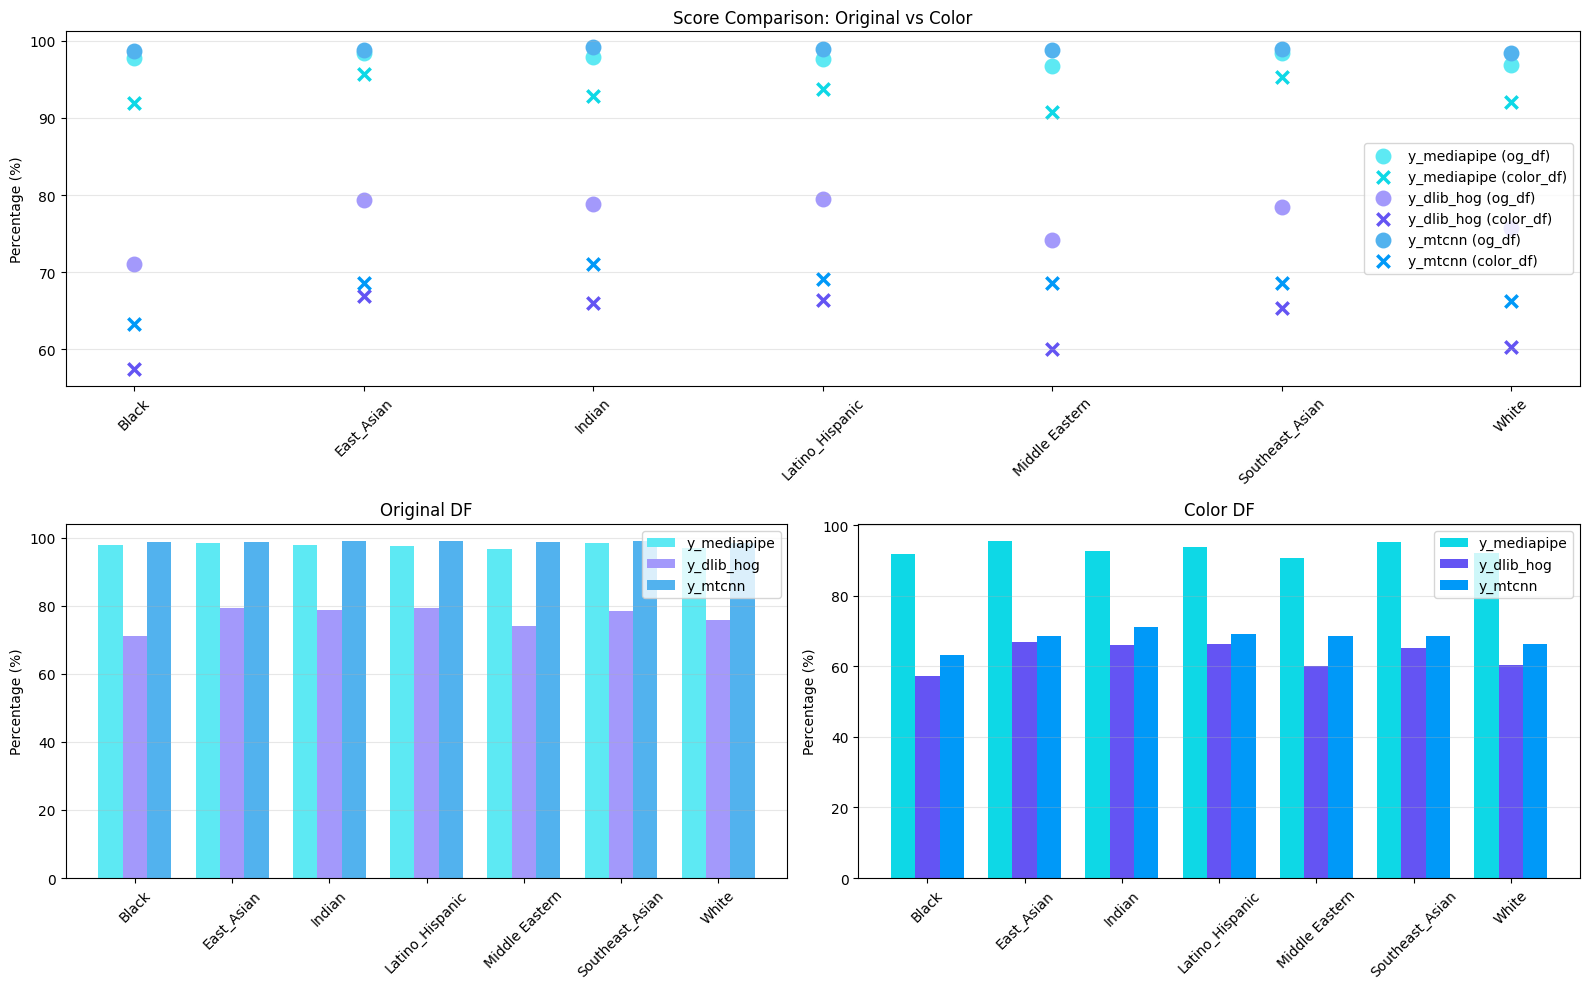

race  y_mediapipe_og  y_dlib_hog_og  y_mtcnn_og  \
0            Black       97.773432      71.039567   98.691139   
1       East_Asian       98.447252      79.296697   98.766936   
2           Indian       97.872973      78.804105   99.137290   
3  Latino_Hispanic       97.630786      79.485073   98.972884   
4   Middle Eastern       96.712944      74.193548   98.836260   
5  Southeast_Asian       98.389860      78.451524   98.955122   
6            White       96.887516      75.740931   98.409429   

   y_mediapipe_color  y_dlib_hog_color  y_mtcnn_color  y_mediapipe_diff  \
0          91.872508         57.393987      63.284600         -5.900924   
1          95.630994         66.972396      68.612676         -2.816258   
2          92.788438         65.978730      71.099212         -5.084536   
3          93.812198         66.421300      69.160276         -3.818589   
4          90.747924         59.997278      68.577310         -5.965020   
5          95.263789         65.330593      68.565148         -3.126071   
6          92.097685         60.296754      66.326239         -4.789831   

   y_dlib_hog_diff  y_mtcnn_diff  
0       -13.645580    -35.406539  
1       -12.324301    -30.154260  
2       -12.825376    -28.038078  
3       -13.063772    -29.812608  
4       -14.196271    -30.258949  
5       -13.120932    -30.389974  
6       -15.444177    -32.083190

In [17]:
SingleColComparison(df_og, df_c, ['race'])
DfComparison(df_og, df_c, ['race'])

Across all racial groups, **MediaPipe** exhibits relatively small and consistent differences between the original and color-altered settings, with performance drops of roughly ``−3%`` to ``−6%``. The similarity of these reductions across races and the low value drop **suggests that MediaPipe’s face detection relies only weakly on color** information and instead depends more on structural or geometric facial cues. The absence of large race-specific deviations implies a comparatively color-invariant behavior, reducing the likelihood that skin tone differences strongly affect its performance.

By comparison, **Dlib HOG** and especially **MTCNN** show much larger and more variable declines when color information is altered. Dlib HOG experiences moderate drops (``−12%`` to ``−15%``), indicating a partial dependence on color cues that affects some racial groups more than others. **MTCNN demonstrates the strongest color dependency**, with substantial decreases (``−28%`` to ``−35%``), suggesting that color information plays a significant role in its face detection pipeline. The larger and uneven drops across races imply that changes in color disproportionately impact certain skin tones, pointing to potential *sensitivity to color-based* features and a higher risk of *race-dependent performance bias*.

### <h3 style="color:olive;"><b>5.2.2 - Gender </b></h3>

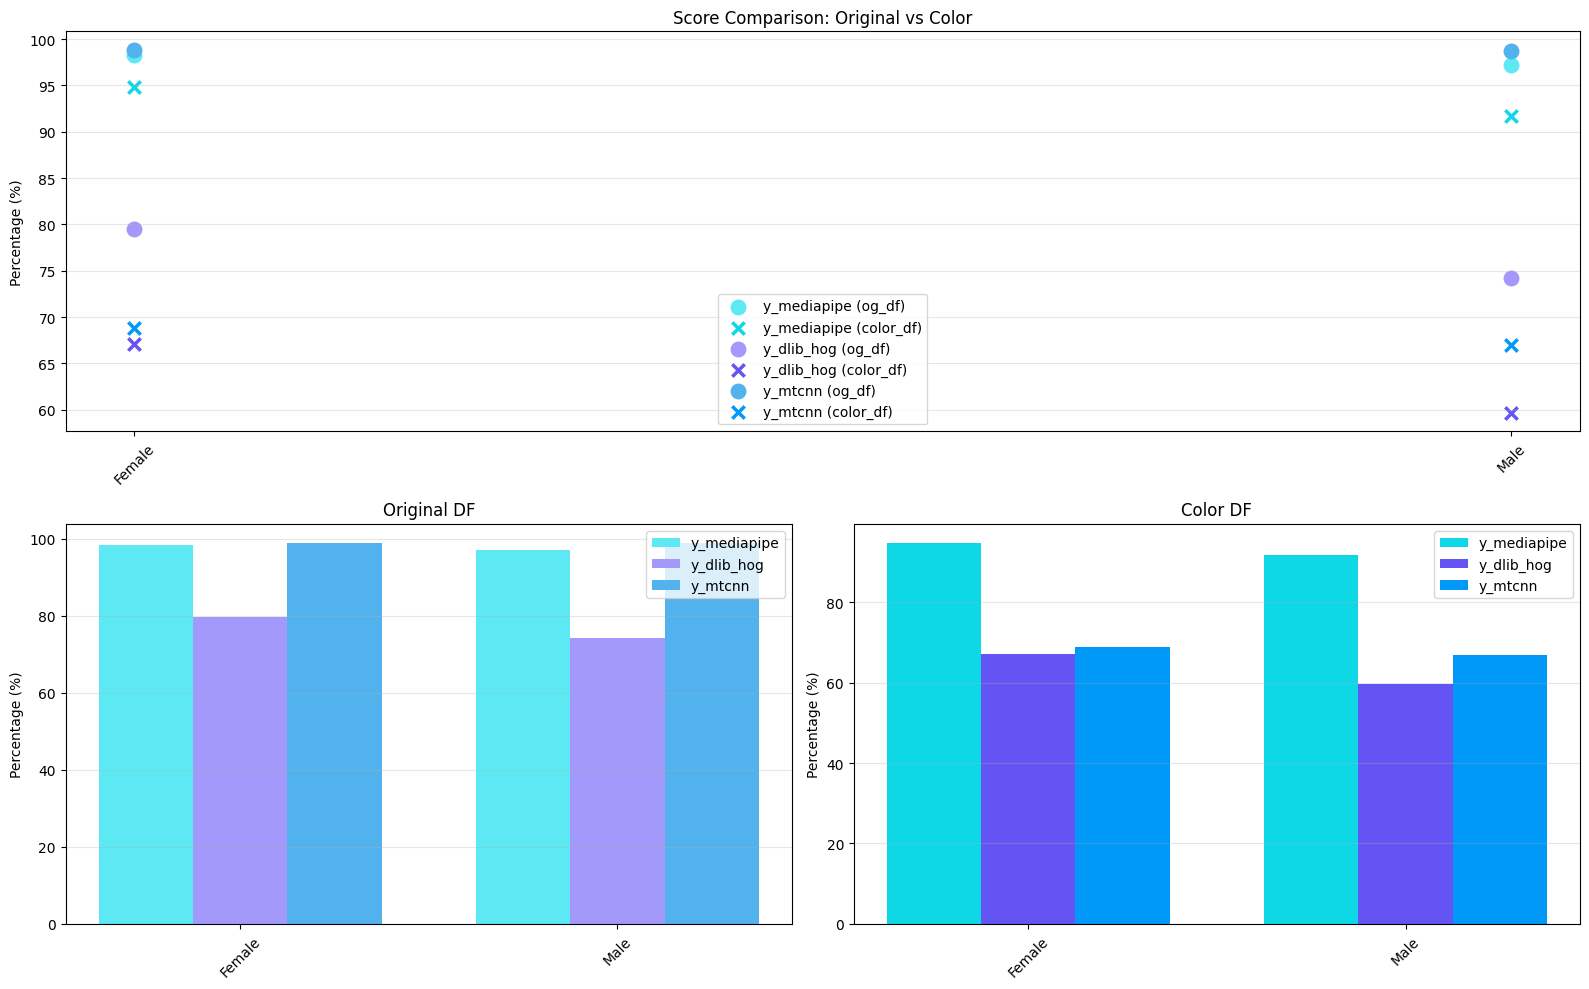

sex  y_mediapipe_og  y_dlib_hog_og  y_mtcnn_og  y_mediapipe_color  \
0  Female       98.222282      79.531614   98.867097          94.800436   
1    Male       97.145669      74.249508   98.749180          91.703634   

   y_dlib_hog_color  y_mtcnn_color  y_mediapipe_diff  y_dlib_hog_diff  \
0         67.087960      68.779106         -3.421846       -12.443653   
1         59.629936      67.019597         -5.442035       -14.619572   

   y_mtcnn_diff  
0    -30.087990  
1    -31.729583

In [18]:
SingleColComparison(df_og, df_c, ['sex'])
DfComparison(df_og, df_c, ['sex'])

Painting the faces caused accuracy drops in both sexes, but the *magnitude* of the drop *differed slightly between males and females* depending on the model. In **MTCNN**, the drop was around ``30%`` for both sexes, with only a *1% difference*, meaning the effect was nearly identical despite the large overall decline. For **MediaPipe**, the drop was much smaller (around ``3–5%``), but the *difference between sexes was proportionally larger*, suggesting a minor influence of sex on how performance was affected. **Dlib-HOG** showed an intermediate pattern, with a roughly ``2%`` difference between males and females.

Overall, the sex-based differences are small, indicating that all models’ performance is only minimally affected by sex when faces are painted. Interestingly, the most stable model in absolute terms (MediaPipe) showed the largest relative difference between sexes, highlighting a subtle but noteworthy link between sex and the way the model responds to changes in facial appearance.

### <h3 style="color:olive;"><b>5.2.3 - Age </b></h3>

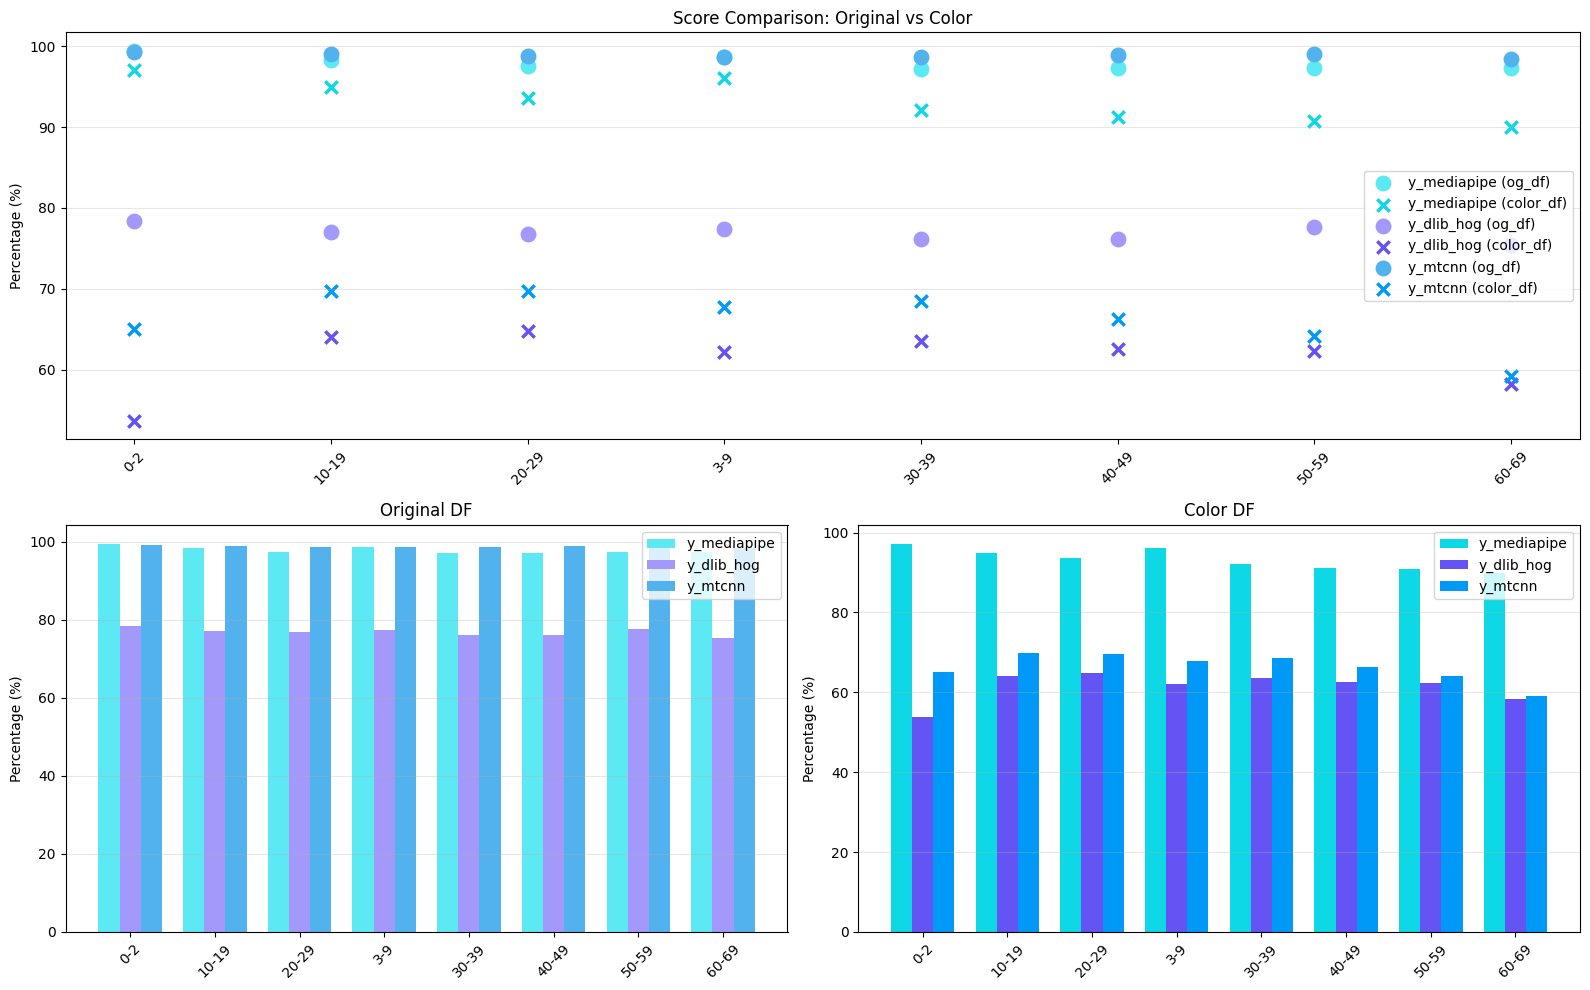

age  y_mediapipe_og  y_dlib_hog_og  y_mtcnn_og  y_mediapipe_color  \
0    0-2       99.408284      78.402367   99.309665          97.090730   
1  10-19       98.317165      77.073847   98.990299          94.982842   
2  20-29       97.531577      76.809816   98.751353          93.576326   
3    3-9       98.591065      77.371134   98.676976          96.103394   
4  30-39       97.143412      76.224252   98.688302          92.080418   
5  40-49       97.260761      76.200640   98.950551          91.238290   
6  50-59       97.330850      77.653631   99.006828          90.764018   
7  60-69       97.314488      75.406360   98.445230          90.000000   

   y_dlib_hog_color  y_mtcnn_color  y_mediapipe_diff  y_dlib_hog_diff  \
0         53.706443      65.080539         -2.317554       -24.695924   
1         64.066521      69.779912         -3.334323       -13.007325   
2         64.786479      69.701071         -3.955251       -12.023337   
3         62.172419      67.738794         -2.487671       -15.198715   
4         63.586604      68.493328         -5.062994       -12.637647   
5         62.587454      66.350943         -6.022471       -13.613186   
6         62.360335      64.196669         -6.566832       -15.293296   
7         58.233216      59.199058         -7.314488       -17.173145   

   y_mtcnn_diff  
0    -34.229126  
1    -29.210387  
2    -29.050283  
3    -30.938182  
4    -30.194973  
5    -32.599609  
6    -34.810159  
7    -39.246172

In [19]:
SingleColComparison(df_og, df_c, ['age'])
DfComparison(df_og, df_c, ['age'])

Painting the faces affected all age groups, but the magnitude of the drop varied across models and ages. In **MTCNN**, the drop was *consistently large* (around`` 29–39%``), with *older age groups* (``50–69``) experiencing **slightly higher declines**, though the differences between age groups are relatively small compared to the overall drop. **MediaPipe** and **Dlib-HOG** showed smaller drops, but in these models the youngest (``0–2``) and oldest (``60–69``) age groups **tended to show slightly larger decreases in accuracy**.

Overall, these results suggest that while all models are somewhat affected by changes in skin appearance, the *dependency on age-related facial cues is minor*. The pattern indicates a* small trend where very young and older faces are more sensitive to changes*, but the effect is subtle. Like with sex, the models’ dependence on skin color is generally low, and the differences across age groups are not dramatic, though they are still interesting to note.

## <h2 style="color:olive;"><b>5.3 - Effect of Colors and Shades on Recognition Performance </b></h2>

merge the two datasets

In [10]:
df_og = df_og.assign(
    id=df_og["old_img_id"].astype(str) + "_og",
    color="og",
    shade="og"
)

df_fuse = pd.concat([df_c, df_og])
df_fuse = df_fuse.sort_values(by=["old_img_id"])
df_fuse.head()


id  old_img_id    age   sex        race   color  shade  \
0      0_Red_light           0  50-59  Male  East_Asian     Red  light   
11     0_roxo_dark           0  50-59  Male  East_Asian    roxo   dark   
10    0_roxo_light           0  50-59  Male  East_Asian    roxo  light   
9    0_indigo_dark           0  50-59  Male  East_Asian  indigo   dark   
8   0_indigo_light           0  50-59  Male  East_Asian  indigo  light   

    y_mediapipe  y_dlib_hog  y_mtcnn  
0             1           1        1  
11            1           1        1  
10            1           1        1  
9             0           0        0  
8             0           0        1

### <h3 style="color:olive;"><b>5.3.1 - Race </b></h3>

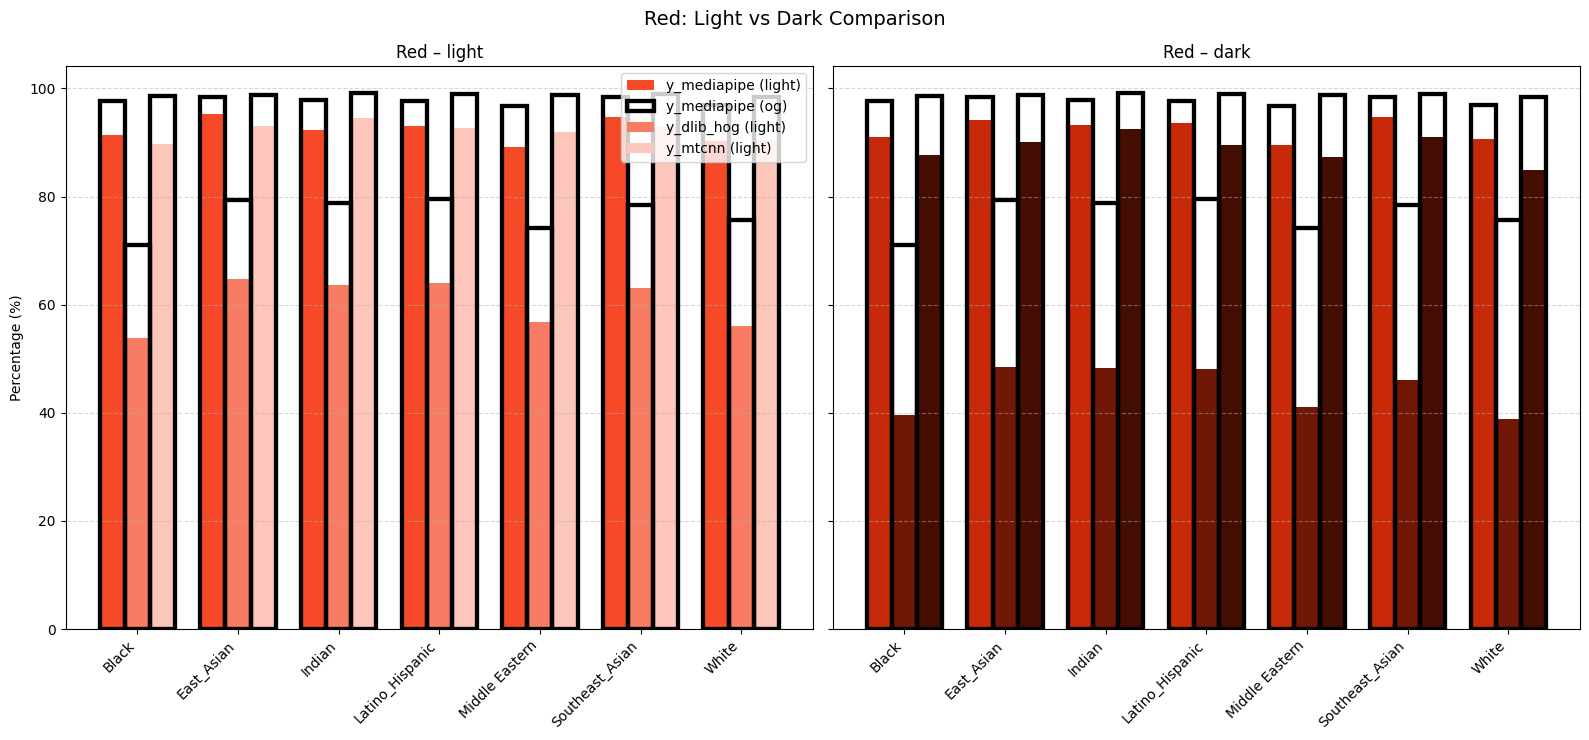

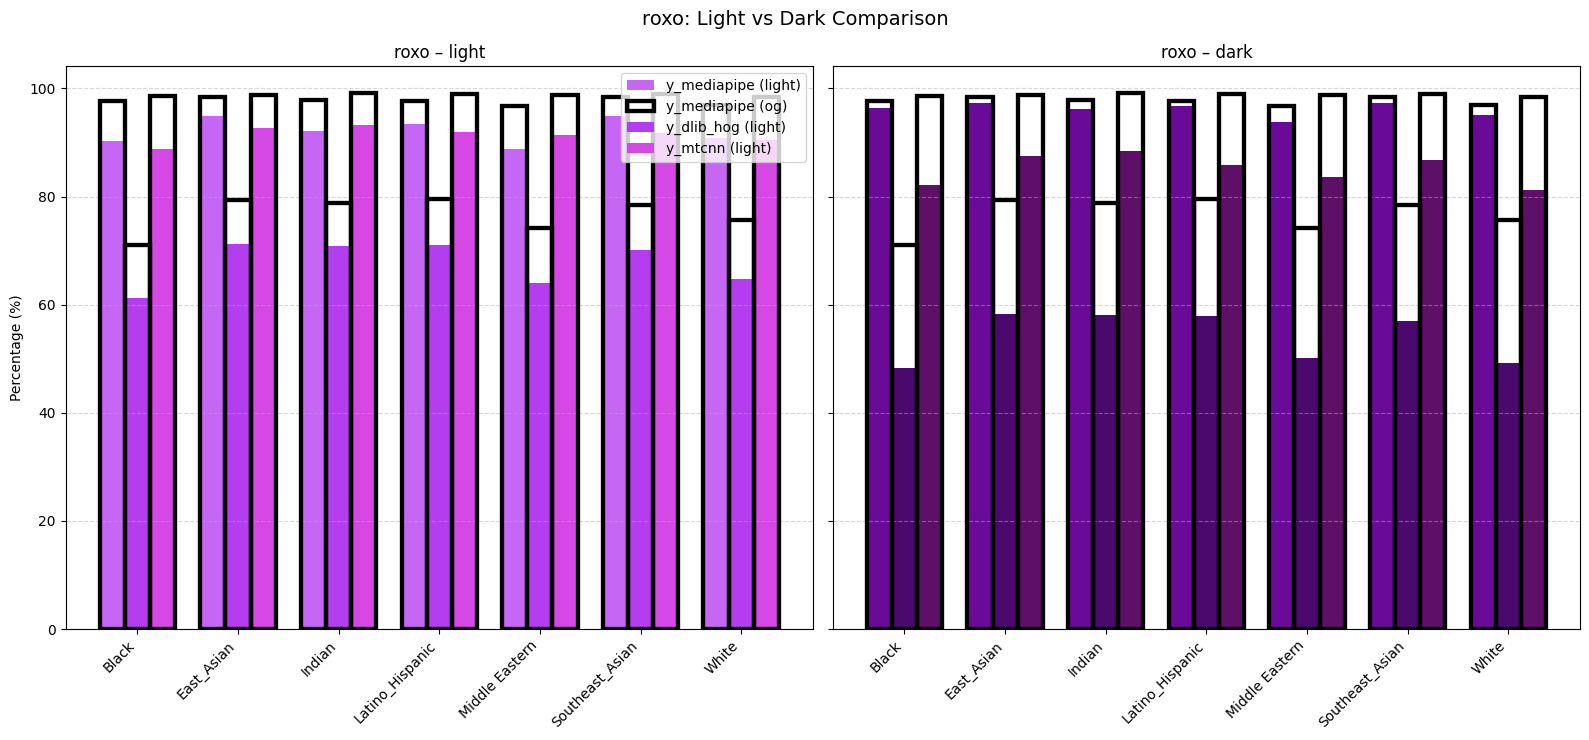

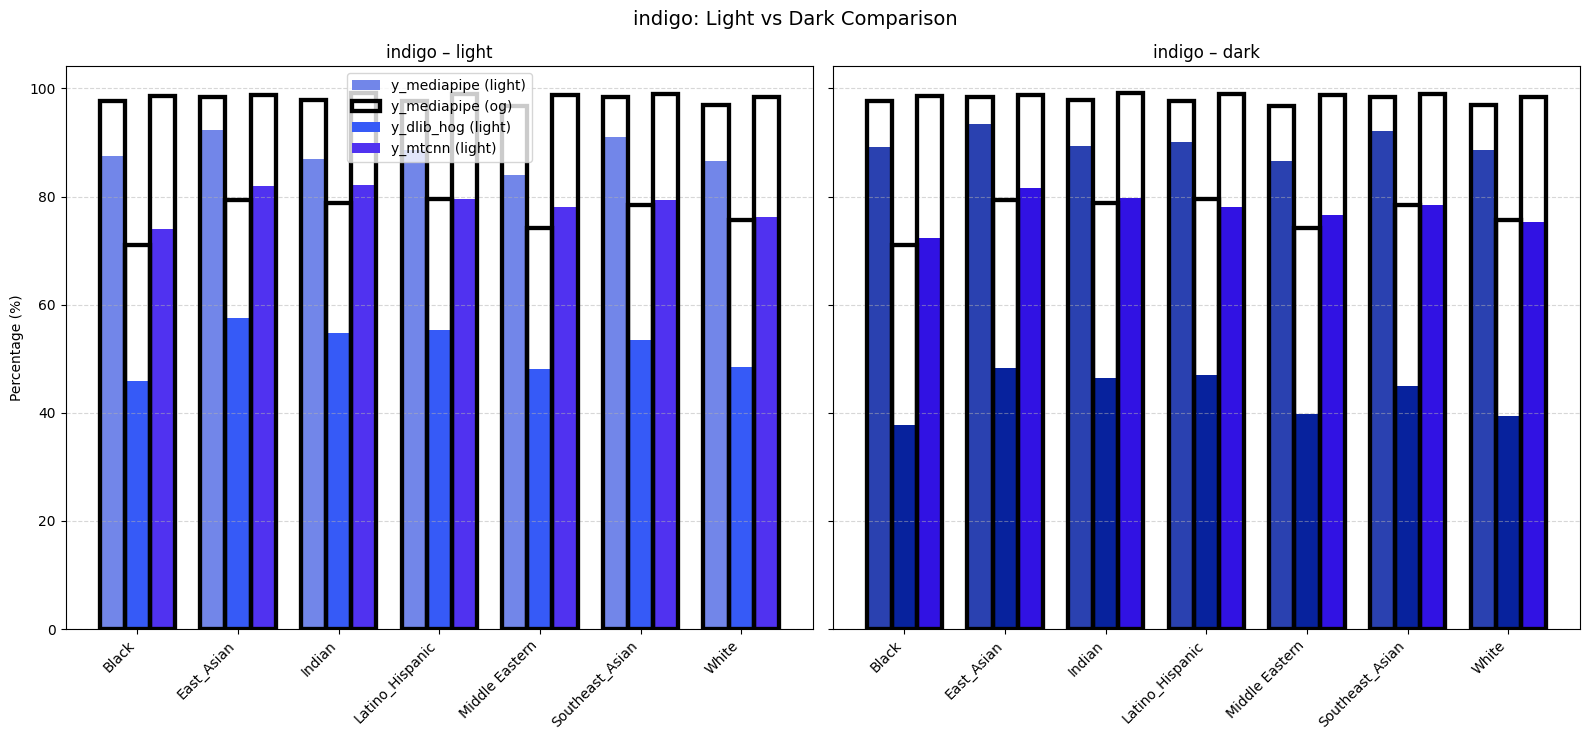

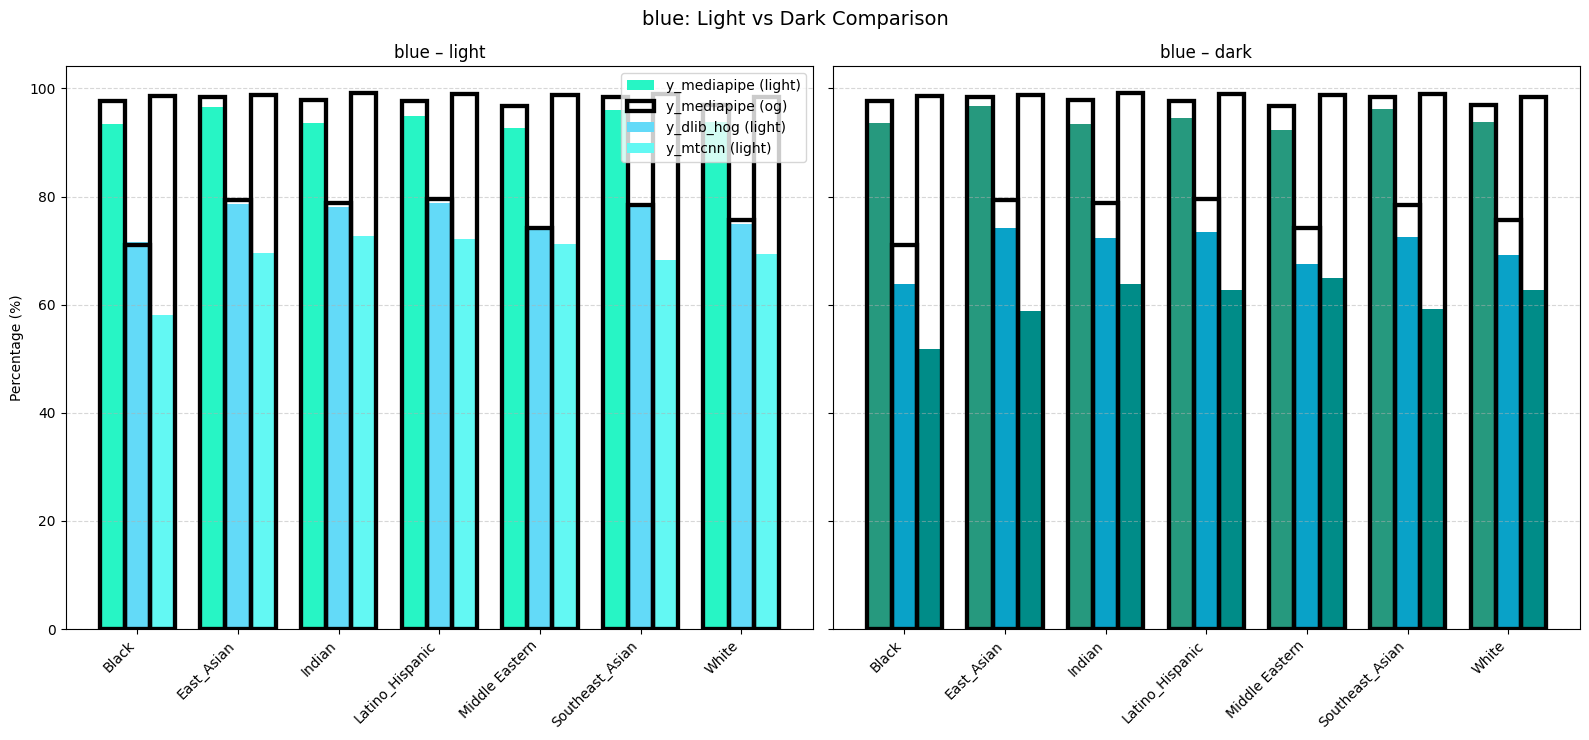

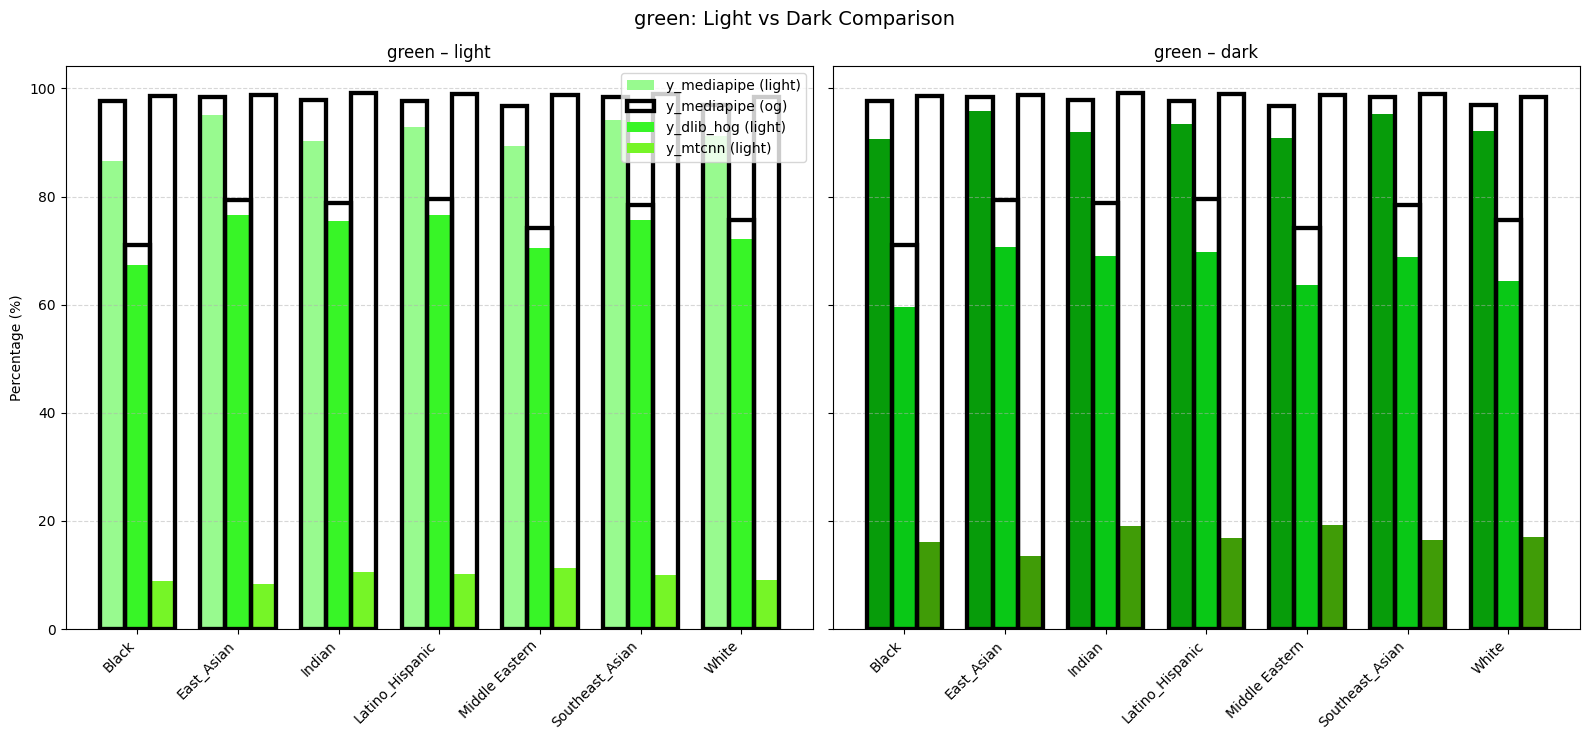

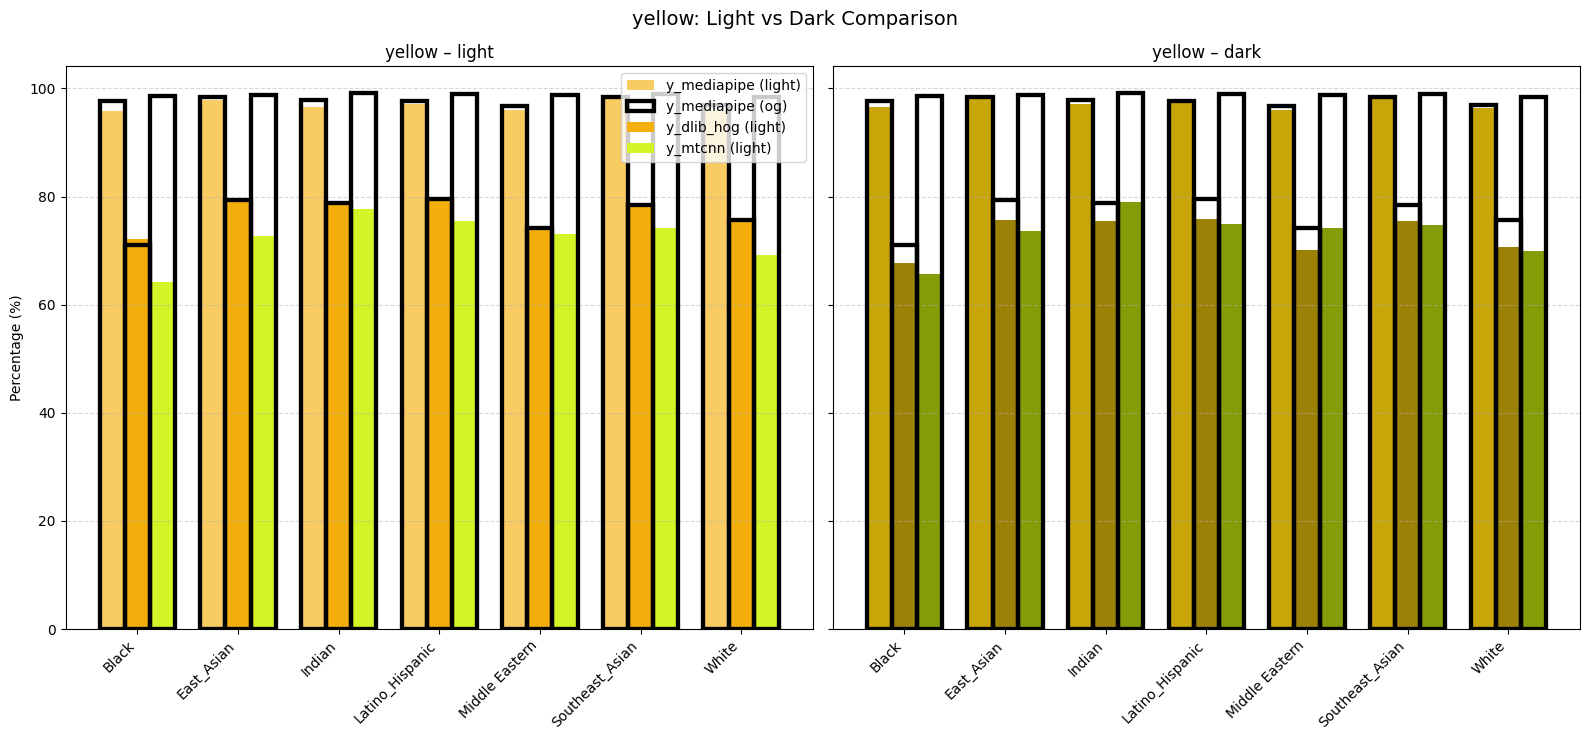

In [21]:
colorShadeComparison(df=df_fuse, col_name=['race'])

In [22]:
df_race = DfColorShade(df=df_fuse, col_name=['race'])
df_race = df_race.filter(like='diff')
df_race.columns
for col in df_race.columns:
    print(df_race[col])

race
Black             -6.754927
East_Asian        -4.231999
Indian            -4.611037
Latino_Hispanic   -3.944125
Middle Eastern    -7.227440
Southeast_Asian   -3.614251
White             -6.327955
Name: y_mediapipe_Red_dark_diff, dtype: float64
race
Black             -11.027531
East_Asian         -8.616228
Indian             -6.559572
Latino_Hispanic    -9.353602
Middle Eastern    -11.494488
Southeast_Asian    -7.965057
White             -13.411145
Name: y_mtcnn_Red_dark_diff, dtype: float64
race
Black             -6.469084
East_Asian        -3.212057
Indian            -5.503495
Latino_Hispanic   -4.656259
Middle Eastern    -7.452021
Southeast_Asian   -3.597122
White             -6.614029
Name: y_mediapipe_Red_light_diff, dtype: float64
race
Black             -17.225816
East_Asian        -14.492312
Indian            -15.186673
Latino_Hispanic   -15.516297
Middle Eastern    -17.374439
Southeast_Asian   -15.416238
White             -19.601785
Name: y_dlib_hog_Red_light_diff, dtype: f

The analysis of color-altered images reveals **consistent performance degradation across all models**, but with notable variation in magnitude across races and colors, indicating model-specific sensitivities rather than uniform failure. Across nearly all color–shade combinations, detection rates decreased relative to the original images, with darker shades generally producing larger drops. However, **the extent of degradation is not evenly distributed across racial groups**, suggesting that the learned facial representations in these models are unevenly robust to synthetic skin-tone perturbations.

MediaPipe shows the **smallest absolute drops overall**, particularly for lighter shades and warmer colors (yellow, green), with deviations typically in the ``1–6%`` range. That said, even within MediaPipe, darker and cooler hues (indigo, red, roxo) *disproportionately affected Black, Middle Eastern, and White* faces, while East Asian faces consistently exhibited smaller relative declines. This pattern suggests that MediaPipe’s detector, while comparatively robust, may still rely on color-linked facial cues that generalize better to certain skin-tone distributions seen during training. Importantly, no color configuration consistently outperformed the original baseline, though yellow (both shades) produced the smallest degradation across most races.

In contrast, **MTCNN and Dlib HOG exhibit substantially larger and more uneven drops**, especially for ``indigo`` and ``red`` variants, with MTCNN showing extreme declines (often exceeding ``20%``) for Black, White, and Middle Eastern faces. Dlib HOG also demonstrates strong sensitivity, particularly to lighter synthetic colors, which likely disrupt its gradient-based feature extraction. The fact that ``East Asian`` and ``Southeast Asian`` faces often experience comparatively **smaller drops** across models may indicate that these **detectors rely more heavily on luminance and contour features that remain more stable under the applied color shifts**. Overall, these results suggest that skin-color bias manifests not only as detection failure rates but as differential robustness to non-natural pigmentation, reflecting implicit assumptions in training data about plausible skin color distributions and reinforcing the importance of testing face detectors under controlled, counterfactual appearance changes.

### <h3 style="color:olive;"><b>5.3.2 - Gender </b></h3>

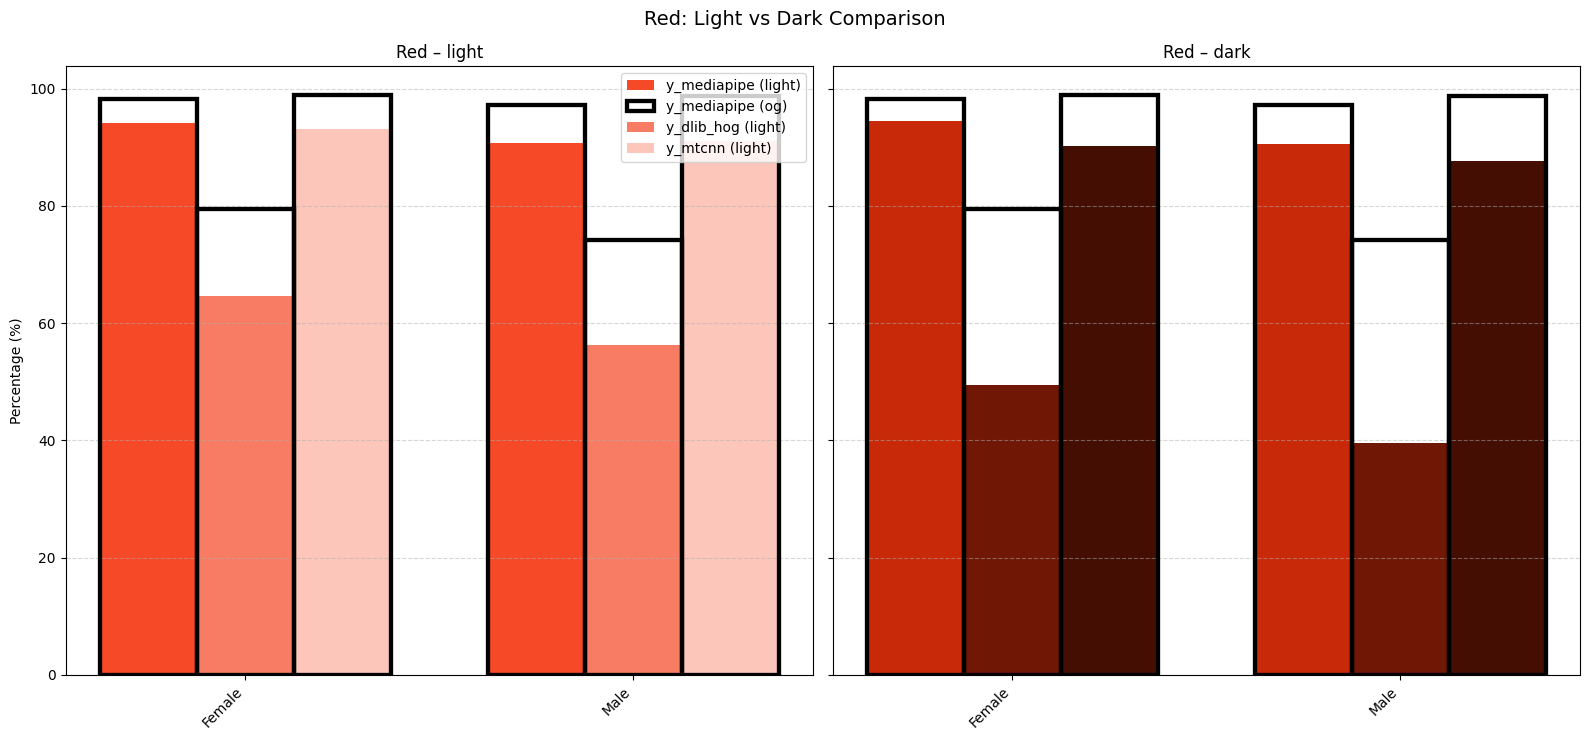

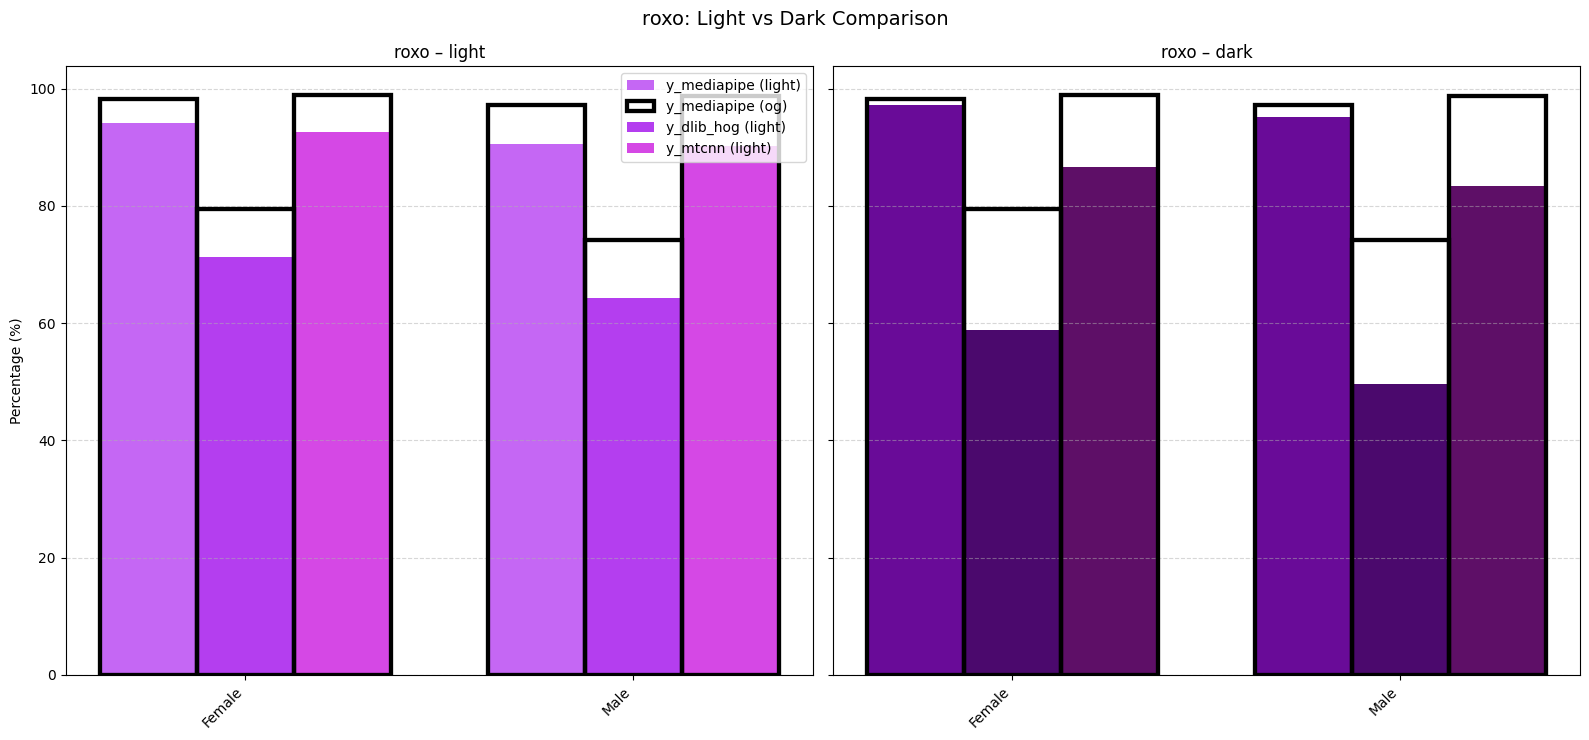

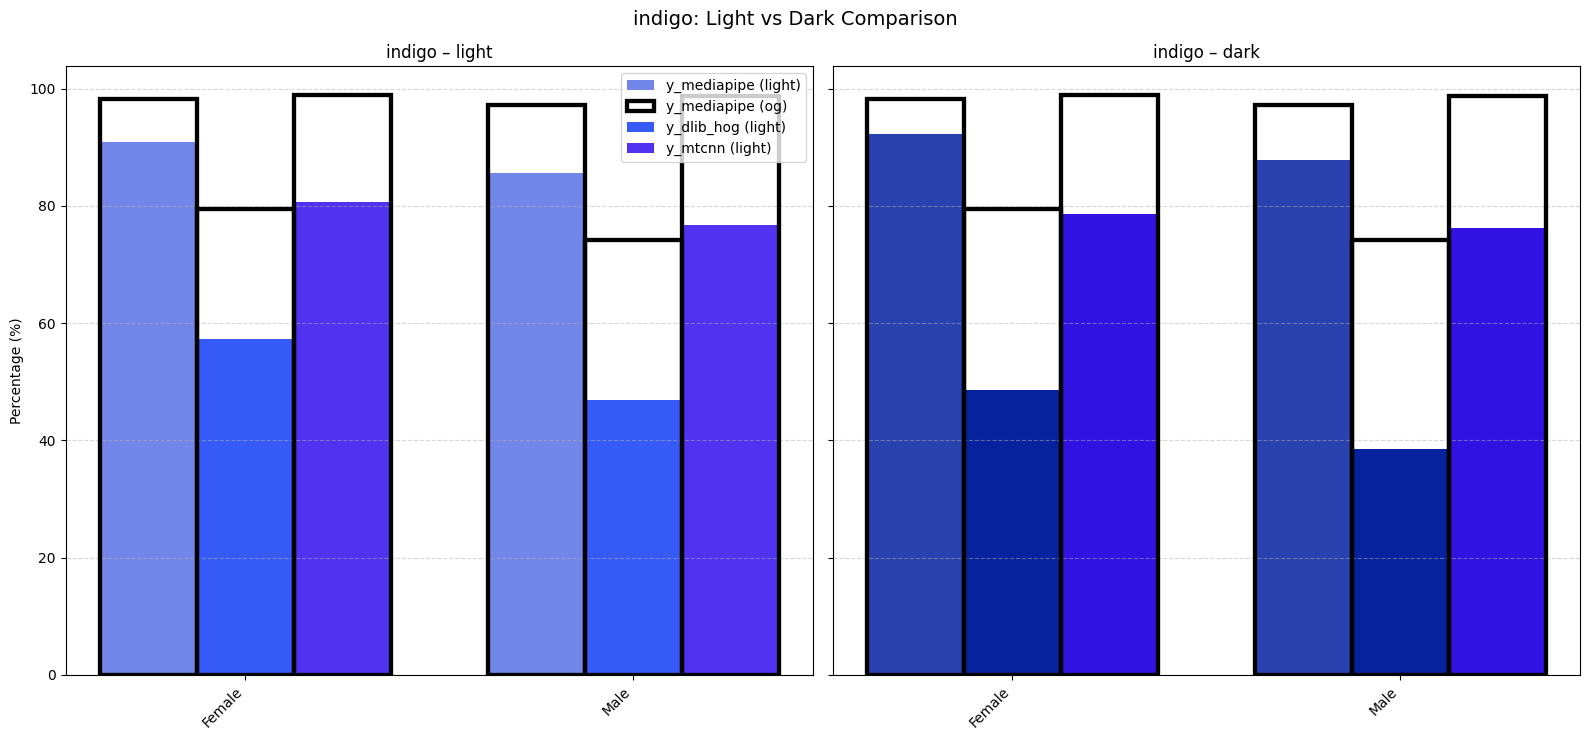

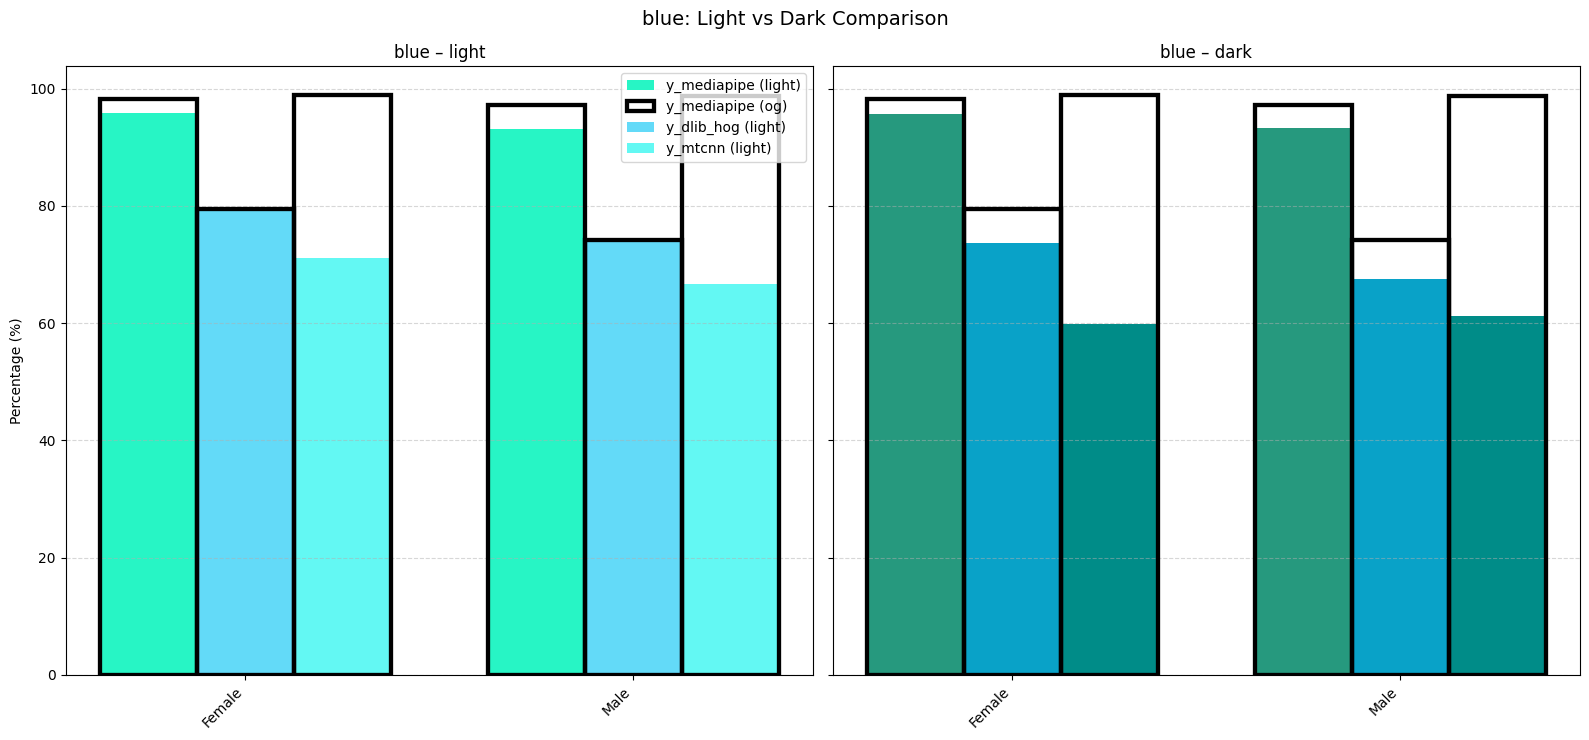

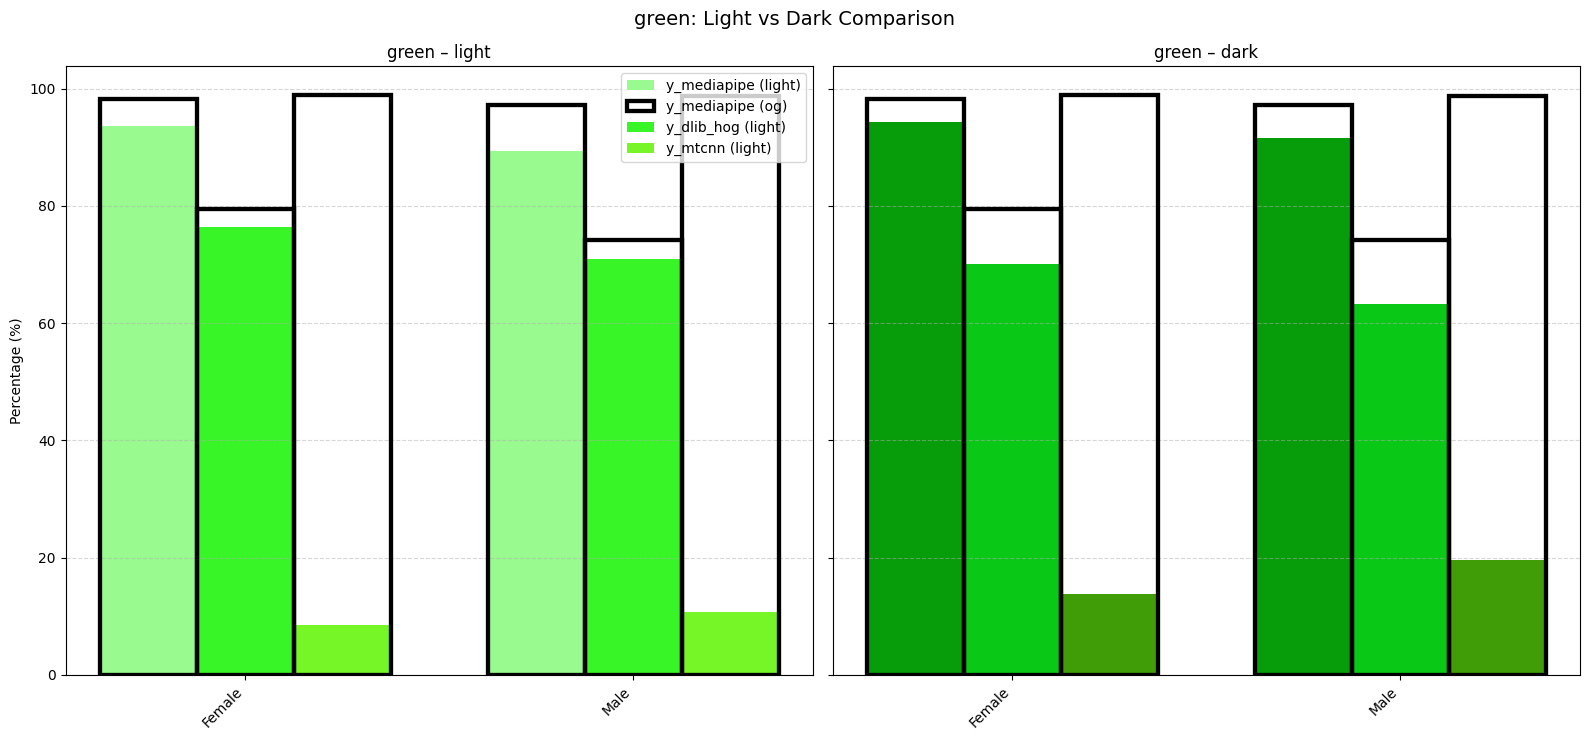

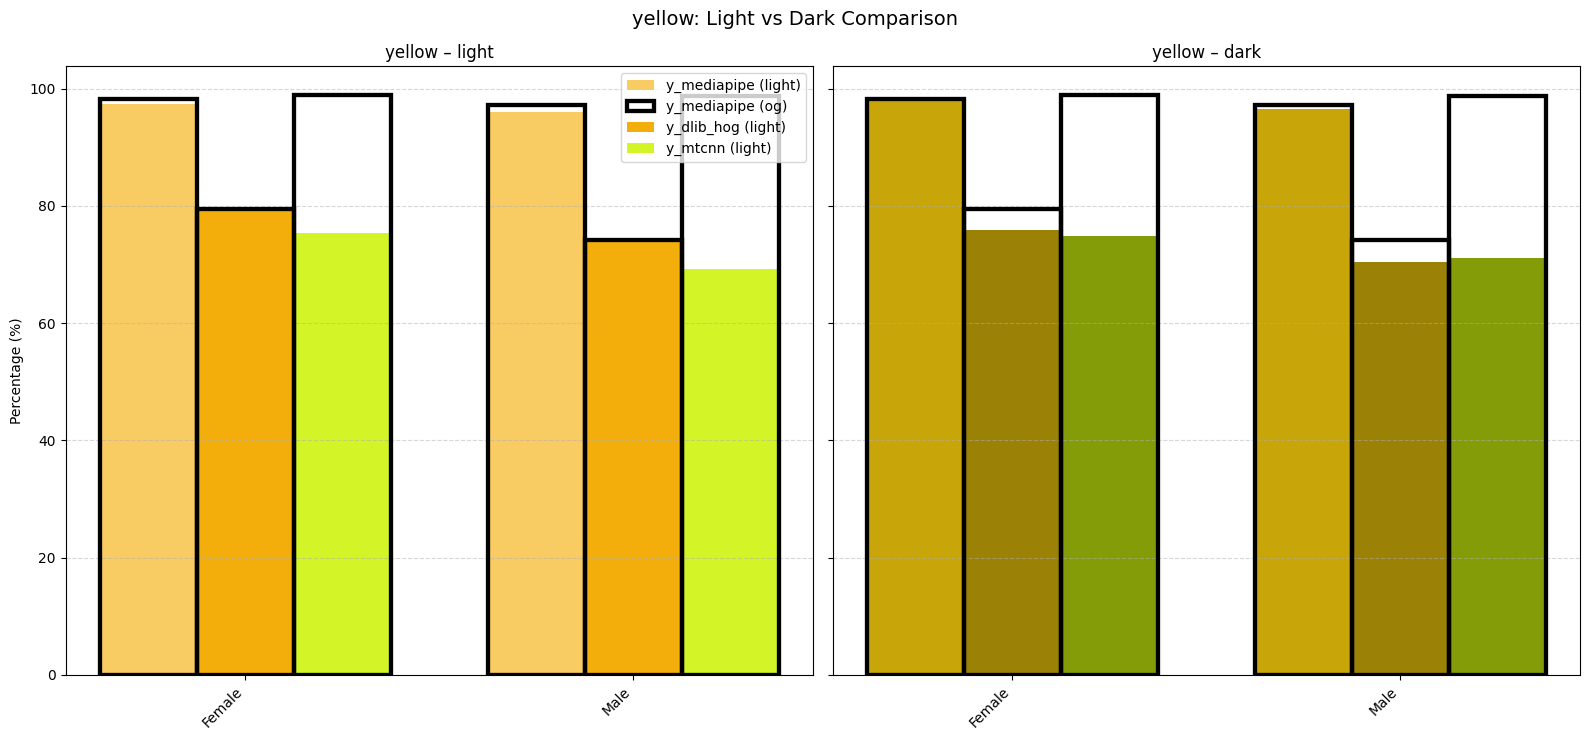

In [8]:
colorShadeComparison(df=df_fuse, col_name=['sex'])

In [24]:
df_sex = DfColorShade(df = df_fuse,col_name=['sex'])
df_sex = df_sex.filter(like='diff')
df_sex.columns
for col in df_sex.columns:
    print(df_sex[col])

sex
Female   -3.721118
Male     -6.610892
Name: y_mediapipe_Red_dark_diff, dtype: float64
sex
Female    -8.633351
Male     -11.052329
Name: y_mtcnn_Red_dark_diff, dtype: float64
sex
Female   -4.159950
Male     -6.459154
Name: y_mediapipe_Red_light_diff, dtype: float64
sex
Female   -14.965073
Male     -17.933891
Name: y_dlib_hog_Red_light_diff, dtype: float64
sex
Female   -5.727208
Male     -7.644357
Name: y_mtcnn_Red_light_diff, dtype: float64
sex
Female   -0.976178
Male     -1.935892
Name: y_mediapipe_roxo_dark_diff, dtype: float64
sex
Female   -12.188787
Male     -15.404226
Name: y_mtcnn_roxo_dark_diff, dtype: float64
sex
Female   -4.155472
Male     -6.652293
Name: y_mediapipe_roxo_light_diff, dtype: float64
sex
Female   -8.293032
Male     -9.901396
Name: y_dlib_hog_roxo_light_diff, dtype: float64
sex
Female   -6.251119
Male     -8.448561
Name: y_mtcnn_roxo_light_diff, dtype: float64
sex
Female   -6.01827
Male     -9.30168
Name: y_mediapipe_indigo_dark_diff, dtype: float64
sex
Female

Across all evaluated models and color–shade combinations, **male faces consistently exhibit larger performance drops than female faces** when skin pigmentation is altered. This pattern holds for every tested color, including both warm (yellow, green) and cool (blue, indigo, roxo) hues, and for both light and dark shades. While the absolute magnitude of degradation varies by model, the direction of the effect is remarkably stable, suggesting a systematic difference in how facial appearance changes interact with sex-linked facial features rather than random variation.

MediaPipe again demonstrates the **highest overall robustness**, with relatively small declines for both sexes, *particularly for lighter shades and yellow tones*, where drops often remain below ``1–2%``. Nevertheless, even in MediaPipe, male faces show noticeably larger decreases than female faces, often by ``2–4`` percentage points for darker or cooler colors. This suggests that MediaPipe’s landmark-driven approach is sensitive to pigmentation changes interacting with facial geometry, possibly due to differences in average facial contrast, hairline visibility, or shadowing patterns that correlate with sex in the training data.

The disparity becomes more pronounced in **MTCNN and Dlib HOG**, where male faces experience severe degradation, **especially for indigo, red, and yellow variants**. In several cases, MTCNN shows drops exceeding ``25%`` for male faces, compared to already substantial but smaller declines for female faces. This behavior indicates that these detectors may rely more heavily on texture, gradient strength, and contrast cues that are disproportionately disrupted by synthetic recoloring on male faces. Overall, the results **suggest a sex-dependent robustness gap**, where face detection systems, particularly older or cascade-based models, are less resilient to appearance shifts on male faces, highlighting an additional axis of bias beyond race that compounds under non-natural skin color conditions.

### <h3 style="color:olive;"><b>5.3.3 - Age </b></h3>

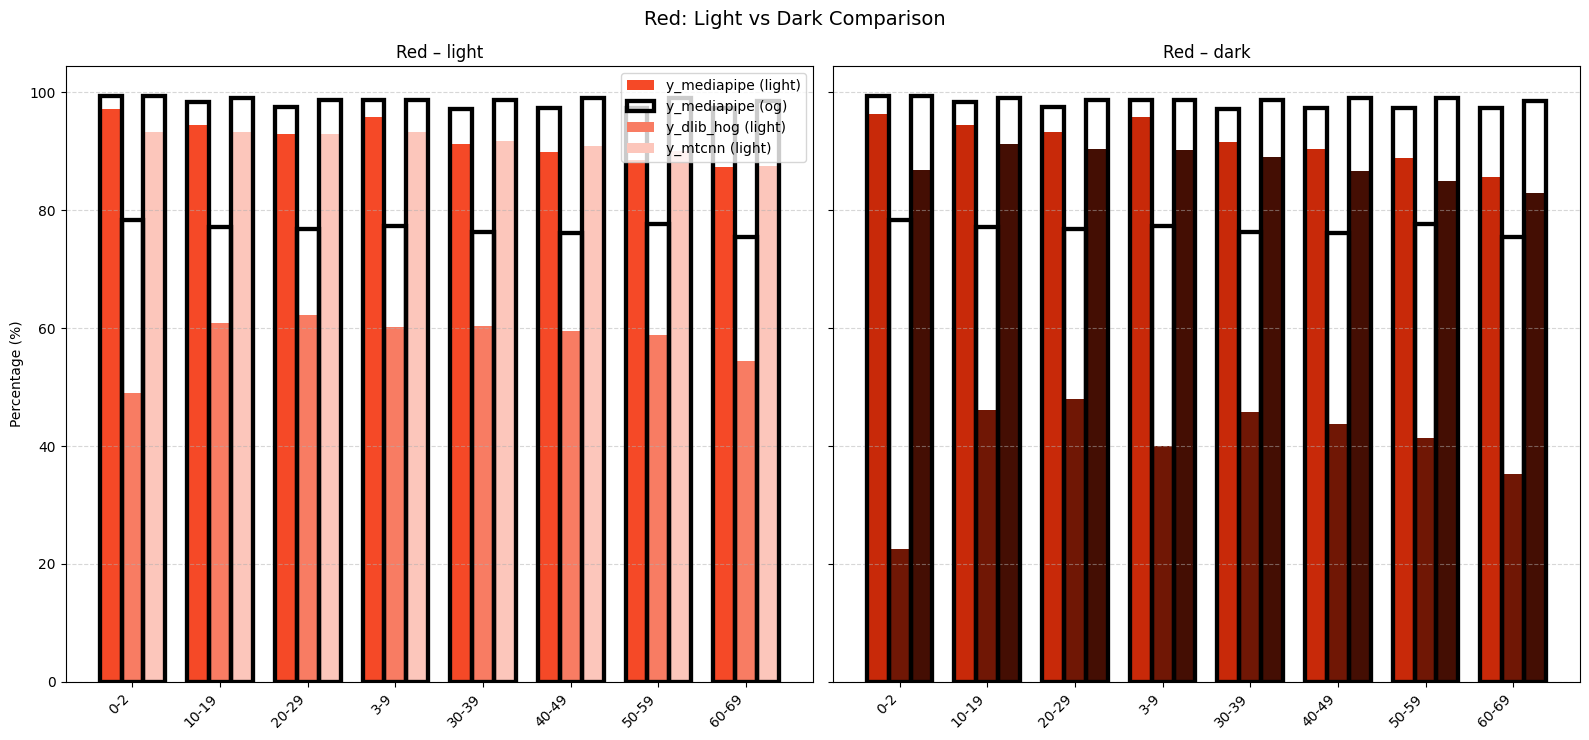

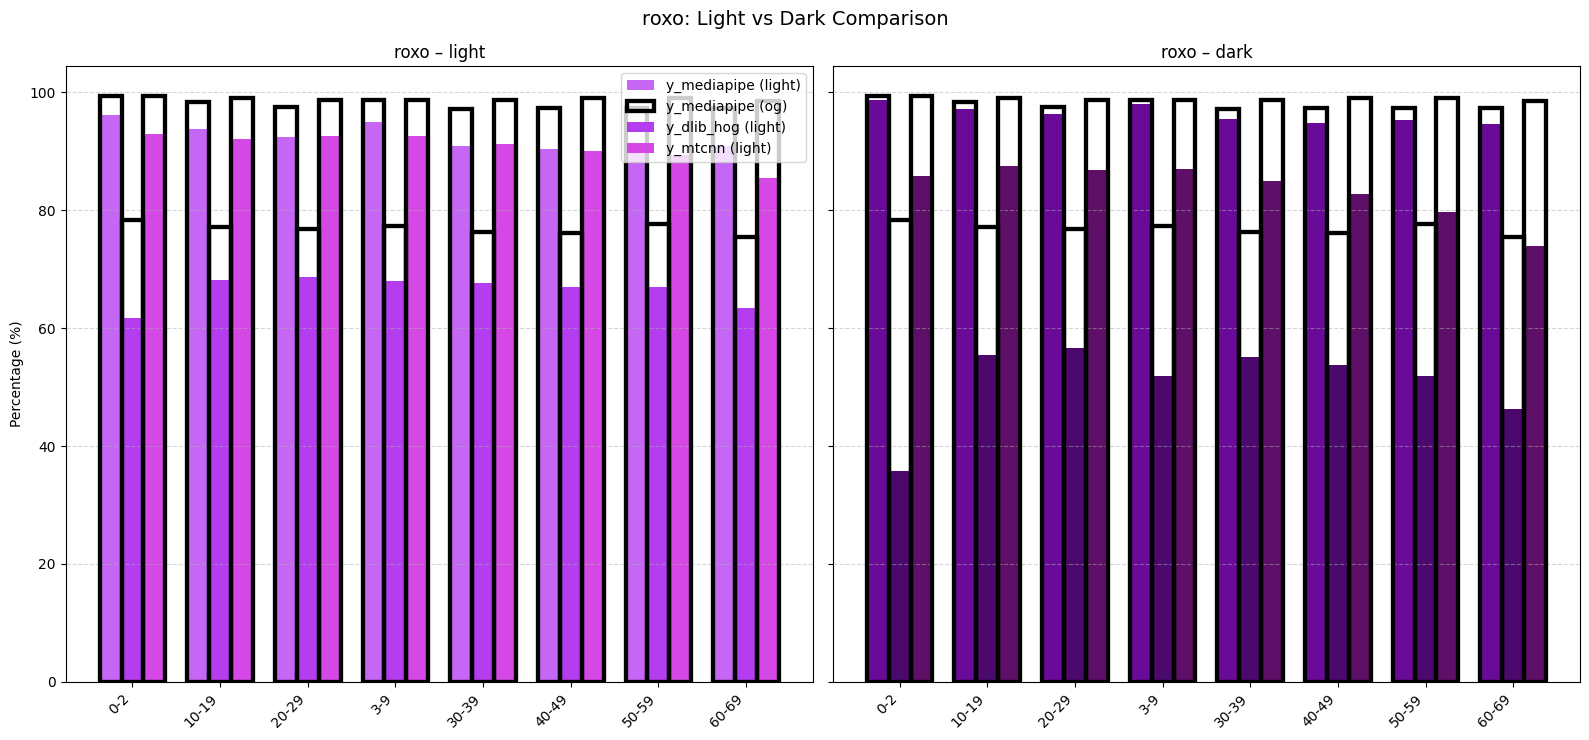

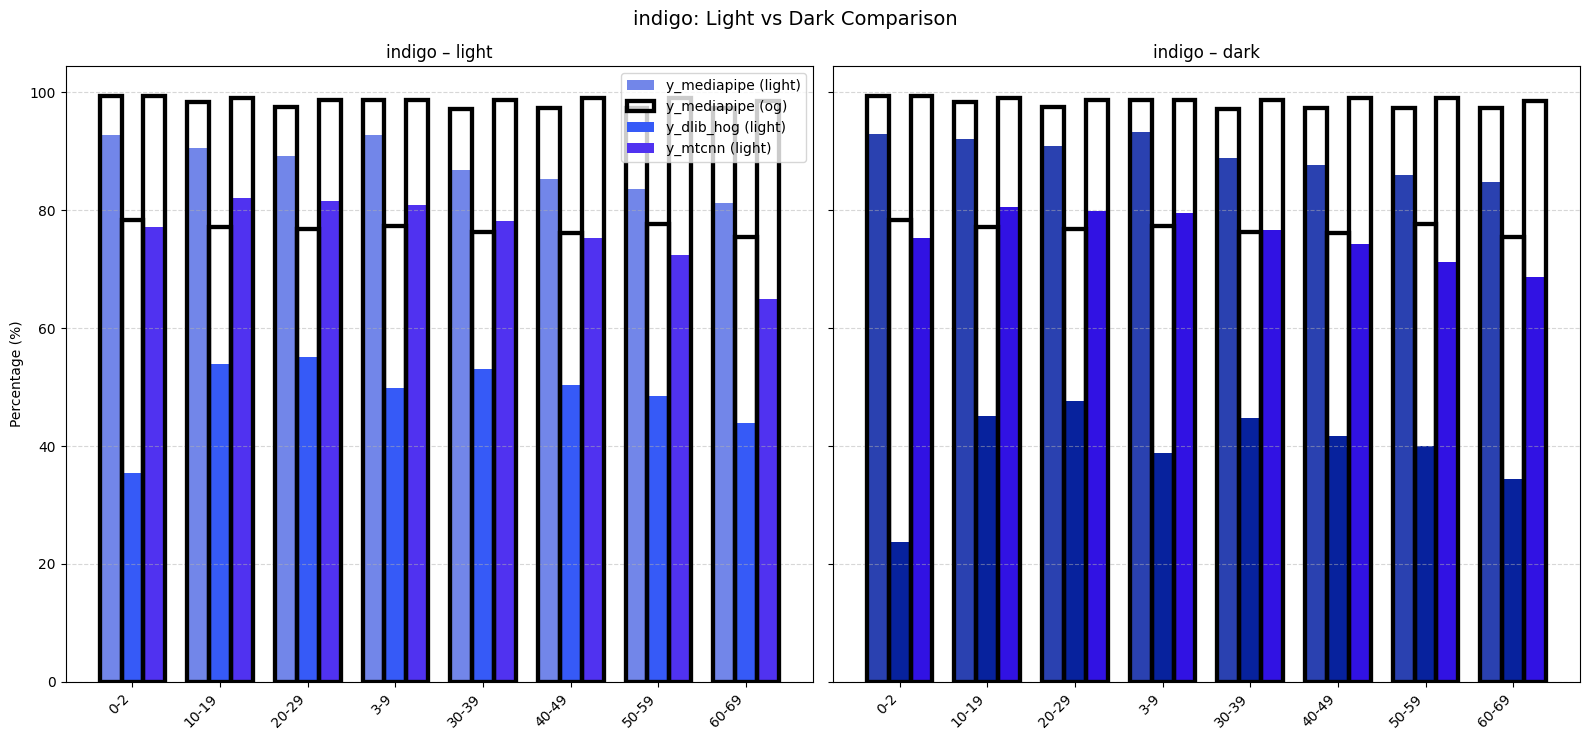

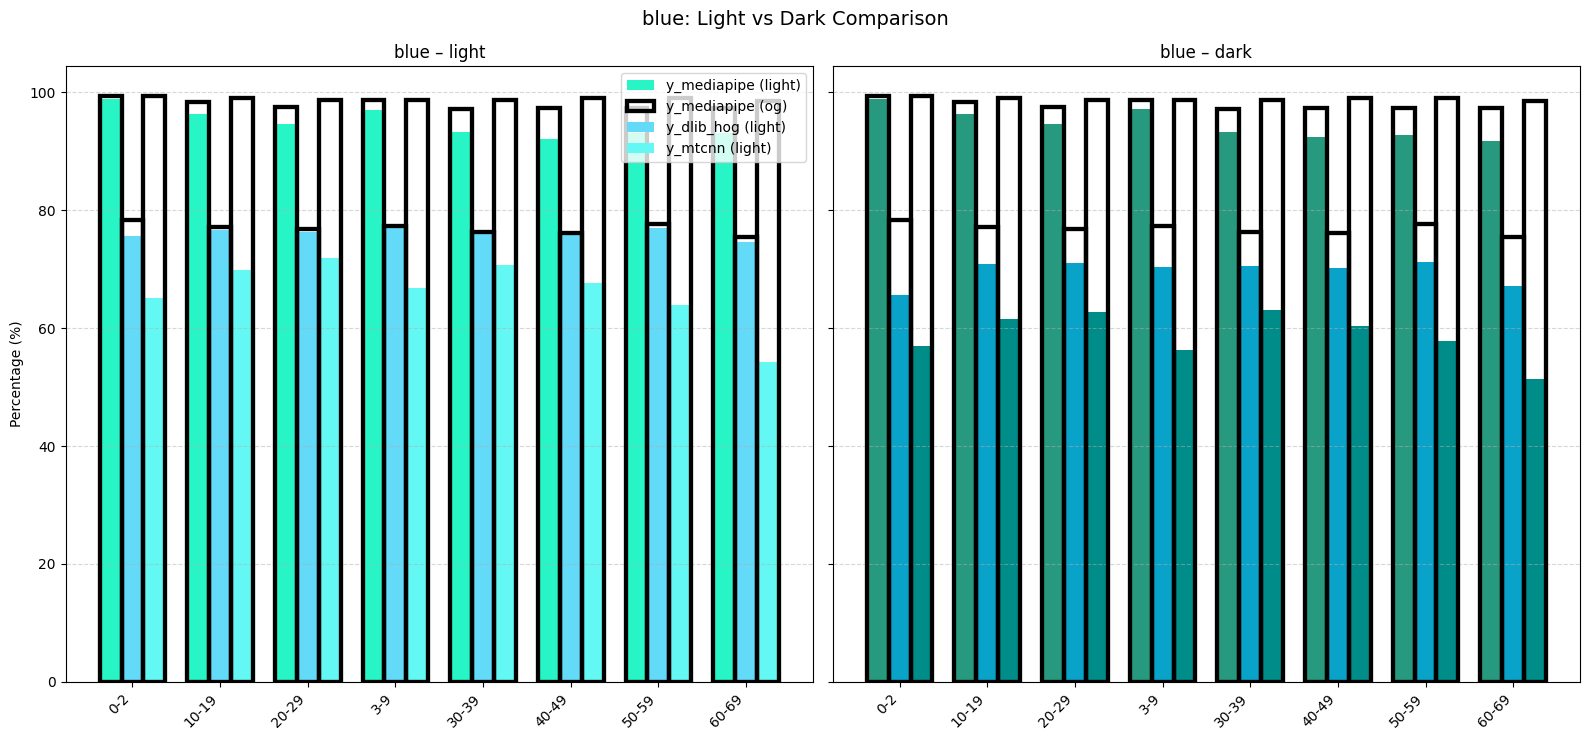

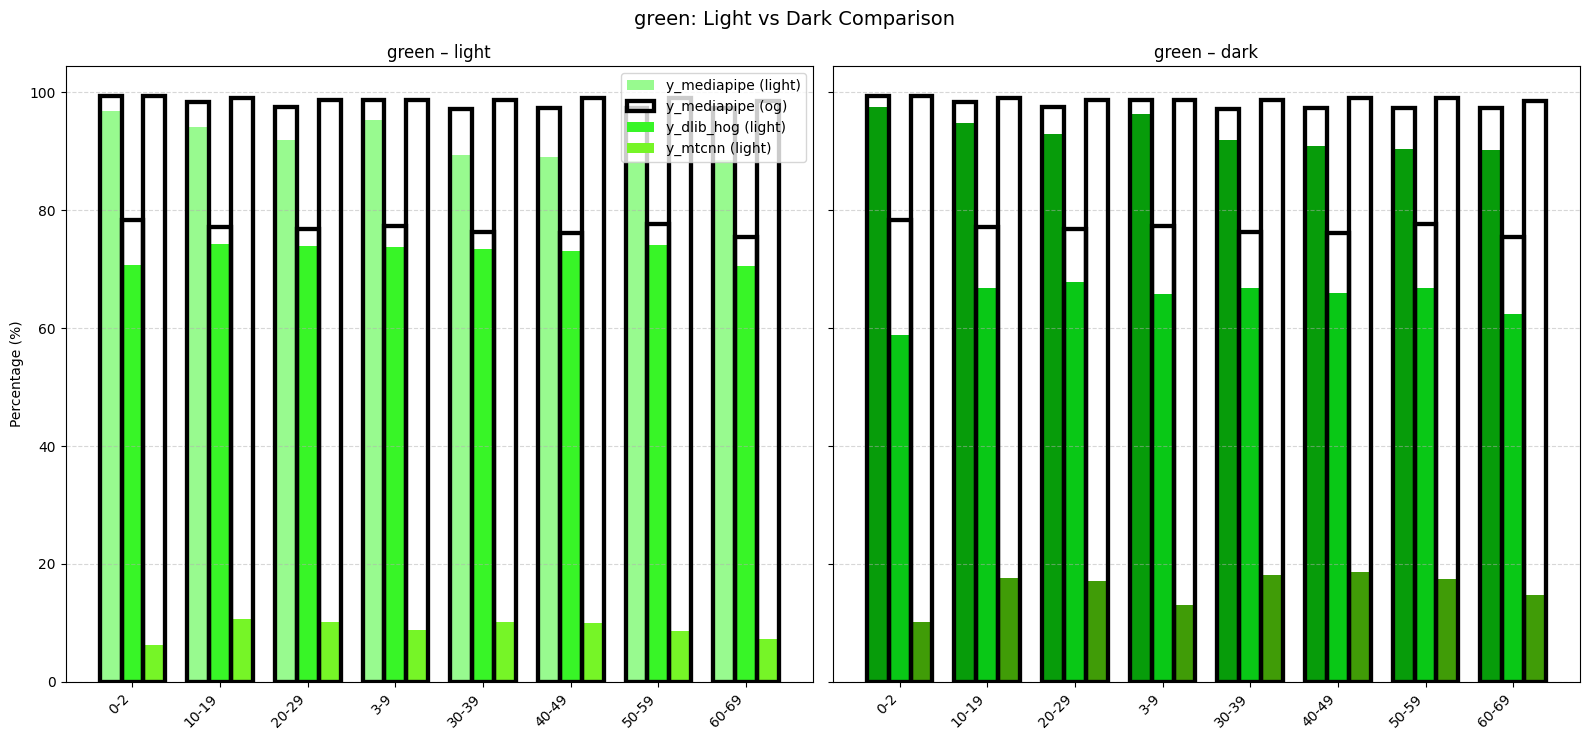

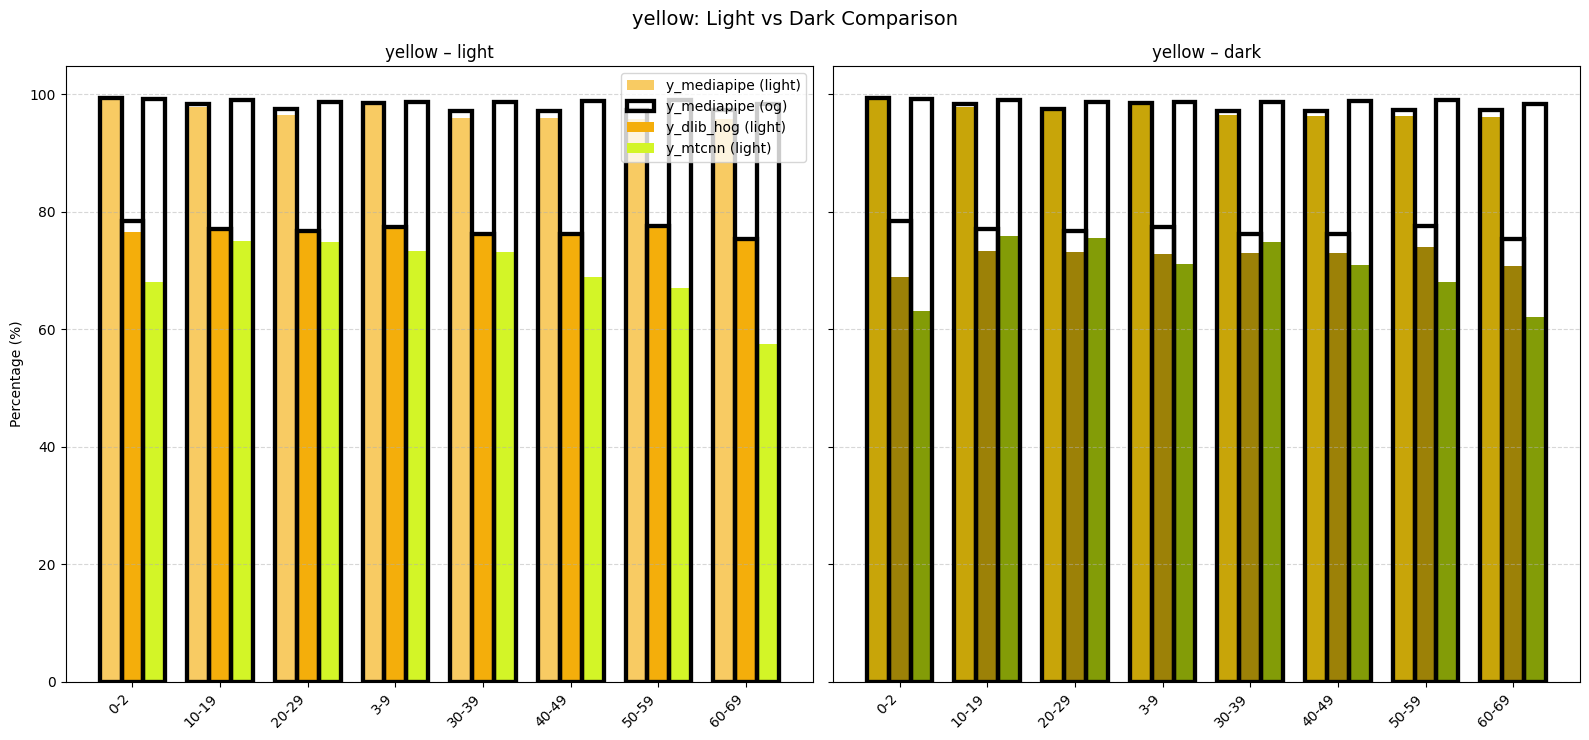

In [25]:
colorShadeComparison(df=df_fuse, col_name=['age'])

In [26]:
df_age = DfColorShade(df = df_fuse,col_name=['age'])
df_age = df_age.filter(like='diff')
df_age.columns
for col in df_age.columns:
    print(df_age[col])

age
0-2      -3.155819
10-19    -3.821026
20-29    -4.272826
3-9      -2.886598
30-39    -5.596580
40-49    -6.901459
50-59    -8.472998
60-69   -11.660777
Name: y_mediapipe_Red_dark_diff, dtype: float64
age
0-2     -12.426036
10-19    -7.800436
20-29    -8.365211
3-9      -8.556701
30-39    -9.716284
40-49   -12.291000
50-59   -14.059590
60-69   -15.618375
Name: y_mtcnn_Red_dark_diff, dtype: float64
age
0-2     -2.268245
10-19   -3.840824
20-29   -4.561530
3-9     -2.783505
30-39   -5.888068
40-49   -7.417289
50-59   -8.814401
60-69   -9.964664
Name: y_mediapipe_Red_light_diff, dtype: float64
age
0-2      -6.114398
10-19    -5.662245
20-29    -5.831830
3-9      -5.395189
30-39    -6.956860
40-49    -8.128780
50-59    -9.031657
60-69   -10.954064
Name: y_mtcnn_Red_light_diff, dtype: float64
age
0-2     -0.690335
10-19   -1.148287
20-29   -1.183688
3-9     -0.601720
30-39   -1.632336
40-49   -2.490217
50-59   -2.110490
60-69   -2.756184
Name: y_mediapipe_roxo_dark_diff, dtype: float64
a

Across all evaluated colors and face recognition models, **performance degradation increases monotonically with age**, indicating that recoloring effects interact strongly with age-related facial characteristics. *Younger* age groups (0–2 and 3–9) consistently show the *smallest deviations*, while *older groups* (particularly 50–59 and 60–69) experience the *largest relative drops for the same color and shade*. This pattern is stable across warm and cool hues, suggesting that the observed differences are driven less by chromatic properties and more by age-correlated facial texture and structure.

MediaPipe exhibits the **smoothest age gradient**, with gradual, near-linear increases in degradation as age rises. Although absolute drops remain comparatively small, older groups still show noticeably larger deviations, especially for *darker* and *cooler* colors (e.g., indigo and roxo). This suggests that while landmark-based detection is generally resilient, it remains sensitive to age-related changes in skin contrast, wrinkle patterns, and shadowing, which are further amplified by synthetic recoloring.

In contrast, **MTCNN and Dlib HOG display sharper age-dependent divergence,** particularly for **darker shades and high-saturation colors**. Older age groups experience disproportionately larger drops compared to younger ones under identical color conditions, in some cases *exceeding double the degradation observed in children or young adults*. This behavior indicates that these models rely more heavily on fine-grained texture, gradient continuity, and contrast cues (features that degrade with age and are further disrupted by color manipulation). Overall, the results highlight age as a compounding factor in face detection robustness, where the same chromatic alteration can have markedly different effects depending on the subject’s age group.

## <h2 style="color:olive;"><b>5.4 - Overall Comparison Between Painted and Original Images </b></h2>

### <h3 style="color:olive;"><b>5.4.1 - General Color Behavior per Model </b></h3>

In [7]:
cols = ["y_mediapipe", "y_dlib_hog", "y_mtcnn"]

result = (
    df_fuse
    .groupby(["color", "shade"])[cols]
    .mean()            # fraction of True (1)
    .mul(100)          # convert to percentage
    .reset_index()
)

print(result)

     color  shade  y_mediapipe  y_dlib_hog    y_mtcnn
0      Red   dark    92.430859   44.248223  88.909581
1      Red  light    92.300283   60.259868  92.077661
2     blue   dark    94.410789   70.482714  60.535160
3     blue  light    94.438617   76.373756  68.768062
4    green   dark    92.873809   66.546077  16.823290
5    green  light    91.403190   73.539548   9.699240
6   indigo   dark    89.928289   43.332977  77.347747
7   indigo  light    88.162261   51.938350  78.659959
8       og     og    97.660331   76.774553  98.805548
9     roxo   dark    96.183239   54.057583  84.938457
10    roxo  light    92.201648   67.642085  91.407471
11  yellow   dark    97.142246   73.021513  72.948732
12  yellow  light    96.733383   76.900353  72.212351


**Red**

 - **MediaPipe**: Both red shades remain close to the original baseline (92.4–92.3% vs. 97.7%), with no meaningful distinction between light and dark. This suggests that MediaPipe’s landmark-based representation is largely invariant to red-channel dominance, with only a modest global contrast effect.

 - **MTCNN**: Performance remains high overall, but dark red (88.9%) shows nearly double the drop observed for light red (92.1%). This indicates sensitivity to luminance compression and shadow amplification introduced by darker red tones.

 - **Dlib HOG**: Red exhibits strong adverse effects, particularly in the dark shade (44.2%), roughly halving detection performance relative to the original. Light red performs better (60.3%) but still reflects substantial degradation, pointing to a heavy reliance on gradient contrast disrupted by red-dominant recoloring.

**Roxo (Purple)**

 - **MediaPipe**: Light roxo (92.2%) behaves similarly to light red, while dark roxo (96.2%) approaches the unaltered baseline, unexpectedly outperforming several other altered colors. This suggests that balanced red–blue mixtures preserve landmark geometry and facial shading cues.

 - **MTCNN**: Light roxo retains strong performance (91.4%), whereas the dark shade (84.9%) exhibits a clearer decline than dark red, implying compounded effects of reduced luminance and altered chromatic balance.

 - **Dlib HOG**: Performance improves relative to red, particularly for the light shade (67.6%), yet darker roxo (54.1%) remains penalized. This reinforces the model’s sensitivity to dark, low-contrast gradients.

**Indigo**

 - **MediaPipe**: Indigo yields slightly worse performance than red (89.9–88.2%), with minimal shade-based divergence. Interestingly, rox (combining red and indigo) outperforms both, suggesting that pure indigo suppresses critical contrast cues.

 - **MTCNN**: A notable drop is observed (77.3–78.7%), with small but consistent shade-related variation, indicating sensitivity to the absence of red-channel information.

 - **Dlib HOG**: Indigo severely impacts performance (43.3–51.9%), reducing accuracy to roughly one-third of the original. The model shows a mild bias against darker shades, consistent with gradient attenuation effects.

**Blue**

 - **MediaPipe**: Blue is among the best-performing altered colors (94.4% for both shades), with negligible shade influence, highlighting strong robustness to blue-channel dominance.

 - **MTCNN**: Performance drops substantially (light blue (68.8%) and dark blue (60.5%)) suggesting that the lack of red severely disrupts learned face priors.

 - **Dlib HOG**: Light blue remains near baseline (76.4%), while dark blue (70.5%) shows a modest decline. This indicates partial resilience, though darker tones still reduce gradient clarity.

**Green**

 - **MediaPipe**: Performance mirrors red (92.9–91.4%), with no striking shade effect.

 - **MTCNN**: Green is the most detrimental color, with catastrophic drops (16.8% dark, 9.7% light). The slightly better performance for dark green suggests that *residual contrast is more influential than hue itself*. These results highlight MTCNN’s strong dependence on red and blue channel features.

 - **Dlib HOG**: In contrast to MTCNN, green performs relatively well (66.5–73.5%), while red and indigo fare worse. This implies that HOG-based features benefit from green-channel contrast, which dominates luminance in RGB images.

**Yellow**

 - **MediaPipe**: Yellow yields the best overall performance among altered colors (96.7–97.1%), with virtually no shade effect, closely matching the unaltered baseline.

 - **MTCNN**: Performance resembles blue (≈72–73%), suggesting that combining red and green does not compensate for the loss of strong red-channel contrast.

 - **Dlib HOG**: Yellow performs exceptionally well (73.0–76.9%), with light yellow slightly outperforming the original baseline. This indicates that high luminance and strong edge definition align well with HOG feature extraction.

---
# <h1 style="color:olive;"><b> 6 - General Takeaway and Societal Implications </b></h1>

Across all experiments, the results consistently demonstrate that skin color manipulation, when decoupled from facial geometry, exposes fundamental differences in how face recognition models encode identity. Models that prioritize geometric structure and landmark relationships, rather than texture or chromatic gradients, exhibit significantly greater robustness to synthetic skin recoloring. Conversely, models that rely heavily on pixel-level contrast, edge orientation, or color-channel intensity show pronounced performance degradation when confronted with non-natural or altered skin tones.

Among the evaluated models, MediaPipe clearly stands out as the most robust to color perturbations. Across all colors, shades, and demographic subdivisions (age, sex, and race), MediaPipe’s performance remains close to the unaltered baseline, with only modest and largely uniform declines. Notably, this robustness extends to extreme chromatic alterations such as blue, green, and indigo, conditions under which other models fail severely. This behavior aligns closely with MediaPipe’s landmark-based design and is further reinforced by its training on FairFace, a dataset explicitly constructed to balance demographic representation. As a result, MediaPipe appears almost color-invariant, effectively abstracting away skin pigmentation as a defining feature of identity.

In contrast, MTCNN and Dlib HOG reveal strong dependencies on low-level visual cues, albeit in different ways. MTCNN shows a pronounced reliance on red and blue channel information, leading to catastrophic failures for green-dominant or low-red faces. Dlib HOG, while more resilient to certain chromatic shifts, is highly sensitive to luminance and edge contrast, particularly struggling with darker, saturated colors that suppress gradient information. These behaviors indicate that both models encode identity in ways that are unintentionally entangled with skin appearance, rather than being driven purely by facial structure.

From a societal perspective, these findings are critical. When face recognition performance varies systematically with skin coloration (even artificially introduced coloration) it implies that real-world variations in skin tone, lighting, makeup, or cultural appearance could lead to unequal system reliability across populations. Models that degrade more strongly for darker or non-standard color distributions risk reinforcing existing biases, disproportionately affecting certain demographic groups. In this context, robustness to color is not merely a technical property but a prerequisite for fairness and ethical deployment.

Overall, the results suggest that robust face recognition systems should minimize reliance on chromatic and texture-based cues and instead emphasize invariant geometric representations. Training on balanced datasets such as FairFace, combined with architectures designed to abstract away superficial appearance traits, appears to be an effective strategy for mitigating color-related bias. MediaPipe’s near-complete insulation from color manipulation serves as a strong empirical example of how design choices and training data directly translate into more equitable model behavior.

---

# <h1 style="color:olive;"><b>7 - Extra: Failure Recovery via Color Perturbation </b></h1>

In [11]:
def og_fail_color_success(
    df: pd.DataFrame,
    model_col: str,
    id_col: str = "old_img_id"
) -> pd.DataFrame:
    """
    Returns all rows where the OG image failed for a given model
    but at least one painted version succeeded.
    """

    # OG failures
    og_fail = (
        df[df["color"] == "og"]
        .loc[lambda x: x[model_col] == 0, id_col]
        .unique()
    )

    # Painted successes for those same images
    recovered = df[
        (df[id_col].isin(og_fail)) &
        (df["color"] != "og") &
        (df[model_col] == 1)
    ]

    return recovered

def recovery_stats(recovered_df: pd.DataFrame, id_col="old_img_id"):
    return {
        "unique_images_recovered": recovered_df[id_col].nunique(),
        "total_successful_variants": len(recovered_df)
    }


In [12]:
mp_recovered   = og_fail_color_success(df_fuse, "y_mediapipe")
mtcnn_recovered = og_fail_color_success(df_fuse, "y_mtcnn")
hog_recovered   = og_fail_color_success(df_fuse, "y_dlib_hog")

In [13]:
print(f"mediapipe: {recovery_stats(mp_recovered)}")
print(f"mtcnn: {recovery_stats(mtcnn_recovered)}")
print(f"dlib hog: {recovery_stats(hog_recovered)}")

mediapipe: {'unique_images_recovered': 1009, 'total_successful_variants': 5848}
mtcnn: {'unique_images_recovered': 289, 'total_successful_variants': 863}
dlib hog: {'unique_images_recovered': 1463, 'total_successful_variants': 4455}


The results show that color-painted variants recover a substantial number of failures across all models, with dlib HOG benefiting the most in terms of unique images recovered, followed by MediaPipe. MediaPipe, however, produces the highest number of successful variants overall, suggesting it is more robust to color changes once recovery occurs, while MTCNN shows comparatively limited recovery from OG failures.

In [14]:
print(mp_recovered["age"].value_counts(normalize=True))
print(mtcnn_recovered["age"].value_counts(normalize=True))
print(hog_recovered["age"].value_counts(normalize=True))


age
20-29    0.313017
30-39    0.259298
40-49    0.129993
3-9      0.092459
10-19    0.087810
50-59    0.075069
60-69    0.031853
0-2      0.010503
Name: proportion, dtype: float64
age
20-29    0.330233
30-39    0.223256
3-9      0.137209
40-49    0.126744
50-59    0.066279
10-19    0.059302
60-69    0.047674
0-2      0.009302
Name: proportion, dtype: float64
age
20-29    0.286391
30-39    0.243060
40-49    0.125254
10-19    0.122771
3-9      0.108328
50-59    0.078538
60-69    0.026856
0-2      0.008802
Name: proportion, dtype: float64


Across all three models, the most prevalent recovered age groups are ``20–29`` and ``30–39``, accounting for approximately 30% and 20–25% of the recovered samples, respectively. In contrast, the least represented age groups are ``60–69`` and ``0–2``, which consistently contribute only a small fraction of the recoveries, at roughly 3–5% and around 1%.

In [15]:
print(mp_recovered["sex"].value_counts(normalize=True))
print(mtcnn_recovered["sex"].value_counts(normalize=True))
print(hog_recovered["sex"].value_counts(normalize=True))


sex
Male      0.594733
Female    0.405267
Name: proportion, dtype: float64
sex
Male      0.539977
Female    0.460023
Name: proportion, dtype: float64
sex
Male      0.550842
Female    0.449158
Name: proportion, dtype: float64


Although males consistently exhibit a higher recovery rate across all models, the distribution by sex remains *relatively balanced overall*, with proportions close to parity (approximately *50%* for each group).

In [16]:
print(mp_recovered["race"].value_counts(normalize=True))
print(mtcnn_recovered["race"].value_counts(normalize=True))
print(hog_recovered["race"].value_counts(normalize=True))


race
White              0.252565
Latino_Hispanic    0.164672
Black              0.135944
Middle Eastern     0.130472
East_Asian         0.116108
Indian             0.111149
Southeast_Asian    0.089090
Name: proportion, dtype: float64
race
White              0.264195
East_Asian         0.161066
Black              0.140209
Southeast_Asian    0.126304
Latino_Hispanic    0.118192
Middle Eastern     0.101970
Indian             0.088065
Name: proportion, dtype: float64
race
Black              0.190123
White              0.174860
East_Asian         0.147026
Southeast_Asian    0.131538
Middle Eastern     0.128844
Indian             0.116947
Latino_Hispanic    0.110662
Name: proportion, dtype: float64


Although ``White`` individuals are consistently well represented in the training data, they still appear as either the first or second most represented group among the recovered samples across all models. Overall, the racial distribution of recoveries is fairly even, with no single group overwhelmingly dominating the results.

In [20]:
print(mp_recovered.groupby(["color", "shade"]).size().sort_values(ascending=False))


color   shade
yellow  dark     643
roxo    dark     584
yellow  light    550
blue    dark     518
Red     dark     491
green   dark     491
blue    light    488
indigo  dark     479
green   light    472
indigo  light    451
Red     light    363
roxo    light    318
dtype: int64


For MediaPipe, recoveries are relatively well distributed across color–shade combinations, with dark yellow, dark roxo and light yellow yielding the highest counts. Overall, darker shades tend to outperform lighter ones, although several light variants—such as yellow, blue, and green—also contribute substantially, indicating that MediaPipe benefits from both shade types rather than relying exclusively on one.

In [21]:
print(mtcnn_recovered.groupby(["color", "shade"]).size().sort_values(ascending=False))


color   shade
roxo    light    141
Red     light    135
indigo  dark     122
Red     dark     116
indigo  light    108
roxo    dark      94
blue    dark      43
yellow  dark      34
blue    light     31
green   dark      16
yellow  light     16
green   light      7
dtype: int64


For MTCNN, the most frequent recovered combinations are light roxo and light red, followed by dark indigo and dark red. In contrast to the previous model, recoveries are more concentrated in a smaller set of colors, and the least effective combinations (particularly light green and light yellow) exhibit very low recovery counts, indicating a weaker impact of these color–shade variants for MTCNN.

In [22]:
print(hog_recovered.groupby(["color", "shade"]).size().sort_values(ascending=False))

color   shade
blue    light    819
yellow  light    805
green   light    524
yellow  dark     507
blue    dark     431
green   dark     321
roxo    light    281
indigo  light    200
Red     light    176
roxo    dark     155
indigo  dark     132
Red     dark     104
dtype: int64


For the dlib HOG model, recoveries are dominated by light-shaded colors, with light blue and light yellow clearly leading, followed by light green. Dark shades still contribute meaningfully, particularly for yellow and blue, but overall, HOG appears to benefit more from lighter color variants compared to the other models.